In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [105]:
df = pd.read_csv('cleaned_data_new.csv', index_col='customer_id')
df.head()

,SHORT_TERM_COUNT,MID_TERM_COUNT,LONG_TERM_COUNT,SHORT_TERM_COUNT_BANK,MID_TERM_COUNT_BANK,LONG_TERM_COUNT_BANK,SHORT_TERM_COUNT_NON_BANK,MID_TERM_COUNT_NON_BANK,LONG_TERM_COUNT_NON_BANK,NUMBER_OF_LOANS,...,OUTSTANDING_BAL_CC_9M_12M_AUGMENTED,OUTSTANDING_BAL_CC_6M_12M_AUGMENTED,OUTSTANDING_BAL_CC_3M_12M_AUGMENTED,OUTSTANDING_BAL_ALL_3M_6M_AUGMENTED,OUTSTANDING_BAL_ALL_6M_9M_AUGMENTED,OUTSTANDING_BAL_ALL_9M_12M_AUGMENTED,OUTSTANDING_BAL_ALL_6M_12M_AUGMENTED,OUTSTANDING_BAL_ALL_3M_12M_AUGMENTED,OUTSTANDING_BAL_CC_CURRENT_AUGMENTED,OUTSTANDING_BAL_ALL_CURRENT_AUGMENTED
customer_id,,,,,,,,,,,,,,,,,,,,,
0,6,2,2,3,1,1,4,1,1,5,...,0.000000,0.000000,0.0,20.000000,15.000000,13.333333,20.000000,40.000000,0.0,70.0
2,11,2,2,4,1,1,7,1,1,11,...,-3.833333,0.000000,0.0,14.857143,15.000000,13.333333,18.518356,29.714286,0.0,80.0
3,11,2,2,1,1,1,10,1,1,11,...,0.000000,-2.507842,0.0,7.903226,11.411043,11.560284,13.191489,11.941003,0.0,200.0
4,5,5,2,1,1,1,4,4,1,8,...,10.000000,10.000000,10.0,9.655349,10.202429,10.623656,10.838710,10.193548,20.0,240.0
6,2,2,2,1,1,1,1,1,1,2,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [106]:
augmented_cols = [col for col in df.columns if 'augmented' in col.lower()]
df.drop(augmented_cols, axis=1, inplace=True)

### 1. Lọc dữ liệu

#### Lựa chọn biến đầu vào

Dựa trên dữ liệu đã phân tích từ vòng 2, nhóm đã quyết định điều chỉnh hoặc các trường dữ liệu sau khỏi biến đầu vào. 

In [107]:
outstanding_cols = [col for col in df.columns if 'outstanding' in col.lower() and 'augmented' not in col.lower()]
outstanding_cols

['OUTSTANDING_BAL_LOAN_CURRENT',
 'OUTSTANDING_BAL_LOAN_3M',
 'OUTSTANDING_BAL_LOAN_6M',
 'OUTSTANDING_BAL_LOAN_9M',
 'OUTSTANDING_BAL_LOAN_12M',
 'OUTSTANDING_BAL_CC_3M',
 'OUTSTANDING_BAL_CC_6M',
 'OUTSTANDING_BAL_CC_9M',
 'OUTSTANDING_BAL_CC_12M',
 'OUTSTANDING_BAL_ALL_3M',
 'OUTSTANDING_BAL_ALL_6M',
 'OUTSTANDING_BAL_ALL_9M',
 'OUTSTANDING_BAL_ALL_12M',
 'OUTSTANDING_BAL_LOAN_3M_6M',
 'OUTSTANDING_BAL_LOAN_6M_9M',
 'OUTSTANDING_BAL_LOAN_9M_12M',
 'OUTSTANDING_BAL_LOAN_6M_12M',
 'OUTSTANDING_BAL_LOAN_3M_12M',
 'OUTSTANDING_BAL_CC_3M_6M',
 'OUTSTANDING_BAL_CC_6M_9M',
 'OUTSTANDING_BAL_CC_9M_12M',
 'OUTSTANDING_BAL_CC_6M_12M',
 'OUTSTANDING_BAL_CC_3M_12M',
 'OUTSTANDING_BAL_ALL_3M_6M',
 'OUTSTANDING_BAL_ALL_6M_9M',
 'OUTSTANDING_BAL_ALL_9M_12M',
 'OUTSTANDING_BAL_ALL_6M_12M',
 'OUTSTANDING_BAL_ALL_3M_12M',
 'OUTSTANDING_BAL_CC_CURRENT',
 'OUTSTANDING_BAL_ALL_CURRENT']

In [108]:
df.iloc[:, -20:].describe()

,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_12M,ENQUIRIES_FROM_BANK_FOR_CC_12M,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M,ENQUIRIES_3M_6M,ENQUIRIES_6M_9M,ENQUIRIES_9M_12M,ENQUIRIES_6M_12M,ENQUIRIES_3M_12M,ENQUIRIES_FROM_BANK_3M_6M,ENQUIRIES_FROM_BANK_6M_9M,ENQUIRIES_FROM_BANK_9M_12M,ENQUIRIES_FROM_BANK_6M_12M,ENQUIRIES_FROM_BANK_3M_12M,ENQUIRIES_FROM_NON_BANK_3M_6M,ENQUIRIES_FROM_NON_BANK_6M_9M,ENQUIRIES_FROM_NON_BANK_9M_12M,ENQUIRIES_FROM_NON_BANK_6M_12M,ENQUIRIES_FROM_NON_BANK_3M_12M,OUTSTANDING_BAL_ALL_CURRENT,label
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000
mean,12.660650,6.819300,2.917750,6.217250,6.394700,6.535850,6.084400,5.548200,3.636850,4.006200,4.267100,3.824200,3.332100,6.492450,6.618500,6.717500,6.437550,6.069750,1.000913e+06,0.182200
std,6.790876,10.252775,2.795975,1.236094,1.117933,0.996074,1.323618,1.571592,1.699093,1.856134,1.939187,1.779397,1.544419,1.062967,0.963174,0.868523,1.100118,1.328448,3.828903e+03,0.386019
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000e+06,0.000000
25%,7.000000,2.000000,2.000000,6.000000,6.000000,7.000000,5.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,7.000000,7.000000,7.000000,6.000000,5.000000,1.000100e+06,0.000000
50%,12.000000,2.000000,2.000000,7.000000,7.000000,7.000000,7.000000,6.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000290e+06,0.000000
75%,17.000000,7.000000,2.000000,7.000000,7.000000,7.000000,7.000000,7.000000,4.000000,6.000000,7.000000,5.000000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000760e+06,0.000000
max,82.000000,142.000000,52.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.169190e+06,1.000000


In [109]:
drop_cols = ['CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD',
       'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD',
       'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT']
df.drop(drop_cols, axis=1, inplace=True)

In [110]:
X = df.drop(columns=['label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [111]:
param = {'num_leaves': 75, 'objective': 'binary'}
param['metric'] = 'auc'

t1 = time.time()
num_round = 100
bst = lgb.train(param, train_data, num_round)
t2 = time.time()
t_lgb = t2 - t1

[LightGBM] [Info] Number of positive: 2915, number of negative: 13085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9918
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182188 -> initscore=-1.501597
[LightGBM] [Info] Start training from score -1.501597


In [112]:
ybar_proba_lgm = bst.predict(X_train)
ybar_lgm = [1 if x >= 0.5 else 0 for x in ybar_proba_lgm]
ypred_proba_lgm = bst.predict(X_test)
ypred_lgm = [1 if x >= 0.5 else 0 for x in ypred_proba_lgm]
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_lgm)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_lgm)*100))
auc_lgm = roc_auc_score(y_test, ypred_proba_lgm)
print('AUC: {}'.format(auc_lgm))
print('Gini: {}'.format(2*auc_lgm-1))

Accuracy for train data: 98.53125%
Accuracy for validation data: 91.725%
AUC: 0.9003815799902625
Gini: 0.8007631599805249


In [113]:
df[df['label']==1].describe()

,SHORT_TERM_COUNT,MID_TERM_COUNT,LONG_TERM_COUNT,SHORT_TERM_COUNT_BANK,MID_TERM_COUNT_BANK,LONG_TERM_COUNT_BANK,SHORT_TERM_COUNT_NON_BANK,MID_TERM_COUNT_NON_BANK,LONG_TERM_COUNT_NON_BANK,NUMBER_OF_LOANS,...,ENQUIRIES_FROM_BANK_9M_12M,ENQUIRIES_FROM_BANK_6M_12M,ENQUIRIES_FROM_BANK_3M_12M,ENQUIRIES_FROM_NON_BANK_3M_6M,ENQUIRIES_FROM_NON_BANK_6M_9M,ENQUIRIES_FROM_NON_BANK_9M_12M,ENQUIRIES_FROM_NON_BANK_6M_12M,ENQUIRIES_FROM_NON_BANK_3M_12M,OUTSTANDING_BAL_ALL_CURRENT,label
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.0,3644.000000,...,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3.644000e+03,3644.0
mean,4.606476,3.322997,2.025247,1.963502,1.276345,1.026345,2.664105,2.050768,1.0,6.000000,...,3.737925,3.477223,3.096048,6.253293,6.329583,6.374588,6.182492,5.949506,1.000448e+06,1.0
std,3.060184,2.356903,0.265955,1.645008,0.979998,0.276974,2.217569,1.996676,0.0,4.283272,...,2.073103,1.928670,1.670199,1.562954,1.540662,1.518636,1.587735,1.659343,2.563016e+03,0.0
min,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000e+06,1.0
25%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,2.000000,...,2.000000,2.000000,2.000000,7.000000,7.000000,7.000000,6.000000,5.000000,1.000000e+06,1.0
50%,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,5.000000,...,3.000000,3.000000,2.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000090e+06,1.0
75%,7.000000,5.000000,2.000000,3.000000,1.000000,1.000000,4.000000,3.000000,1.0,8.000000,...,7.000000,5.000000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000380e+06,1.0
max,23.000000,17.000000,5.000000,10.000000,10.000000,4.000000,16.000000,13.000000,1.0,26.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.101190e+06,1.0


In [114]:
df[df['label']==0].describe()

,SHORT_TERM_COUNT,MID_TERM_COUNT,LONG_TERM_COUNT,SHORT_TERM_COUNT_BANK,MID_TERM_COUNT_BANK,LONG_TERM_COUNT_BANK,SHORT_TERM_COUNT_NON_BANK,MID_TERM_COUNT_NON_BANK,LONG_TERM_COUNT_NON_BANK,NUMBER_OF_LOANS,...,ENQUIRIES_FROM_BANK_9M_12M,ENQUIRIES_FROM_BANK_6M_12M,ENQUIRIES_FROM_BANK_3M_12M,ENQUIRIES_FROM_NON_BANK_3M_6M,ENQUIRIES_FROM_NON_BANK_6M_9M,ENQUIRIES_FROM_NON_BANK_9M_12M,ENQUIRIES_FROM_NON_BANK_6M_12M,ENQUIRIES_FROM_NON_BANK_3M_12M,OUTSTANDING_BAL_ALL_CURRENT,label
count,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,...,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,16356.000000,1.635600e+04,16356.0
mean,7.588347,4.549890,2.068293,3.447603,1.672292,1.067131,4.117633,2.883712,1.002568,10.211788,...,4.384996,3.901504,3.384691,6.545732,6.682869,6.793898,6.494375,6.096539,1.001016e+06,0.0
std,3.151968,3.148154,0.442383,2.114198,1.578700,0.447985,2.414185,2.525284,0.093798,4.143235,...,1.888041,1.735037,1.510010,0.906608,0.763507,0.613724,0.949037,1.241260,4.050300e+03,0.0
min,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,1.000010e+06,0.0
25%,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,8.000000,...,3.000000,3.000000,2.000000,7.000000,7.000000,7.000000,6.000000,5.000000,1.000130e+06,0.0
50%,8.000000,4.000000,2.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,10.000000,...,3.000000,3.000000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000340e+06,0.0
75%,8.000000,5.000000,2.000000,4.000000,1.000000,1.000000,5.000000,4.000000,1.000000,13.000000,...,7.000000,5.000000,3.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000850e+06,0.0
max,26.000000,23.000000,8.000000,13.000000,22.000000,7.000000,16.000000,19.000000,7.000000,35.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.169190e+06,0.0


In [12]:
def check_corr(df, threshold):
    correlation = df.corr()
    for col in correlation.columns:
        for row in correlation.index:
            if correlation.loc[row, col] > threshold and row != col:
                return True
    return False

i=0
keep_cols = []
while check_corr(df, 0.5) and len(df.columns) > i+1 and len(df.columns) > 20:
    best_corr = df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False).index[i+1]
    keep_cols.append(best_corr)
    correlation = df.corrwith(df[best_corr]).sort_values(ascending=False)
    for row in correlation.index:
        if abs(correlation[row]) > 0.5 and row not in keep_cols and row != best_corr:
            df.drop(row, axis=1, inplace=True)
            # print(row)
    i+=1
    print(len(df.columns))

101
89
85
85
77
77
73
60
41
39
37
37
34
34
34
34
25
24
21


In [13]:
df.columns

Index(['LONG_TERM_COUNT', 'MID_TERM_COUNT_BANK', 'SHORT_TERM_COUNT_NON_BANK',
       'LONG_TERM_COUNT_NON_BANK', 'NUMBER_OF_LOANS', 'NUMBER_OF_CREDIT_CARDS',
       'NUMBER_OF_CREDIT_CARDS_NON_BANK', 'NUM_NEW_LOAN_TAKEN_3M',
       'OUTSTANDING_BAL_ALL_3M', 'OUTSTANDING_BAL_LOAN_9M_12M',
       'INCREASING_BAL_6M_LOAN', 'INCREASING_BAL_6M_CC',
       'INCREASING_BAL_3M_ALL', 'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M',
       'ENQUIRIES_FOR_LOAN_12M', 'ENQUIRIES_FROM_NON_BANK_FOR_CC_12M',
       'ENQUIRIES_6M_9M', 'ENQUIRIES_9M_12M', 'ENQUIRIES_FROM_BANK_9M_12M',
       'ENQUIRIES_FROM_NON_BANK_3M_6M', 'label'],
      dtype='object')

In [14]:
df.corrwith(df['label']).apply(lambda x: abs(x)).sort_values(ascending=False)[:50]

label                                  1.000000
OUTSTANDING_BAL_LOAN_9M_12M            0.416869
NUMBER_OF_LOANS                        0.363330
INCREASING_BAL_6M_LOAN                 0.236300
SHORT_TERM_COUNT_NON_BANK              0.229505
NUMBER_OF_CREDIT_CARDS                 0.206043
NUM_NEW_LOAN_TAKEN_3M                  0.179006
INCREASING_BAL_6M_CC                   0.166324
ENQUIRIES_FROM_BANK_9M_12M             0.128807
ENQUIRIES_FOR_LOAN_12M                 0.127882
ENQUIRIES_9M_12M                       0.111141
ENQUIRIES_FROM_NON_BANK_3M_6M          0.106200
MID_TERM_COUNT_BANK                    0.102203
ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M    0.083437
NUMBER_OF_CREDIT_CARDS_NON_BANK        0.069200
ENQUIRIES_6M_9M                        0.066890
INCREASING_BAL_3M_ALL                  0.059437
OUTSTANDING_BAL_ALL_3M                 0.057973
LONG_TERM_COUNT                        0.039927
ENQUIRIES_FROM_NON_BANK_FOR_CC_12M     0.015348
LONG_TERM_COUNT_NON_BANK               0

In [115]:
logistic = LogisticRegression()
t1 = time.time()
logistic.fit(X_train_scaled, y_train)
t2 = time.time()
ybar_logistic = logistic.predict(X_train_scaled)
ypred_logistic = logistic.predict(X_test_scaled)
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_logistic)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_logistic)*100))
print('AUC: {}'.format(roc_auc_score(y_test, ypred_logistic)))
print('Gini: {}'.format(2*roc_auc_score(y_test, ypred_logistic)-1))
t_logistic = t2 - t1
print('Time taken: {}'.format(t_logistic))

Accuracy for train data: 88.1625%
Accuracy for validation data: 88.47500000000001%
AUC: 0.7061999724057991
Gini: 0.41239994481159825
Time taken: 0.21797966957092285


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\2212490852.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\2212490852.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
C:\U

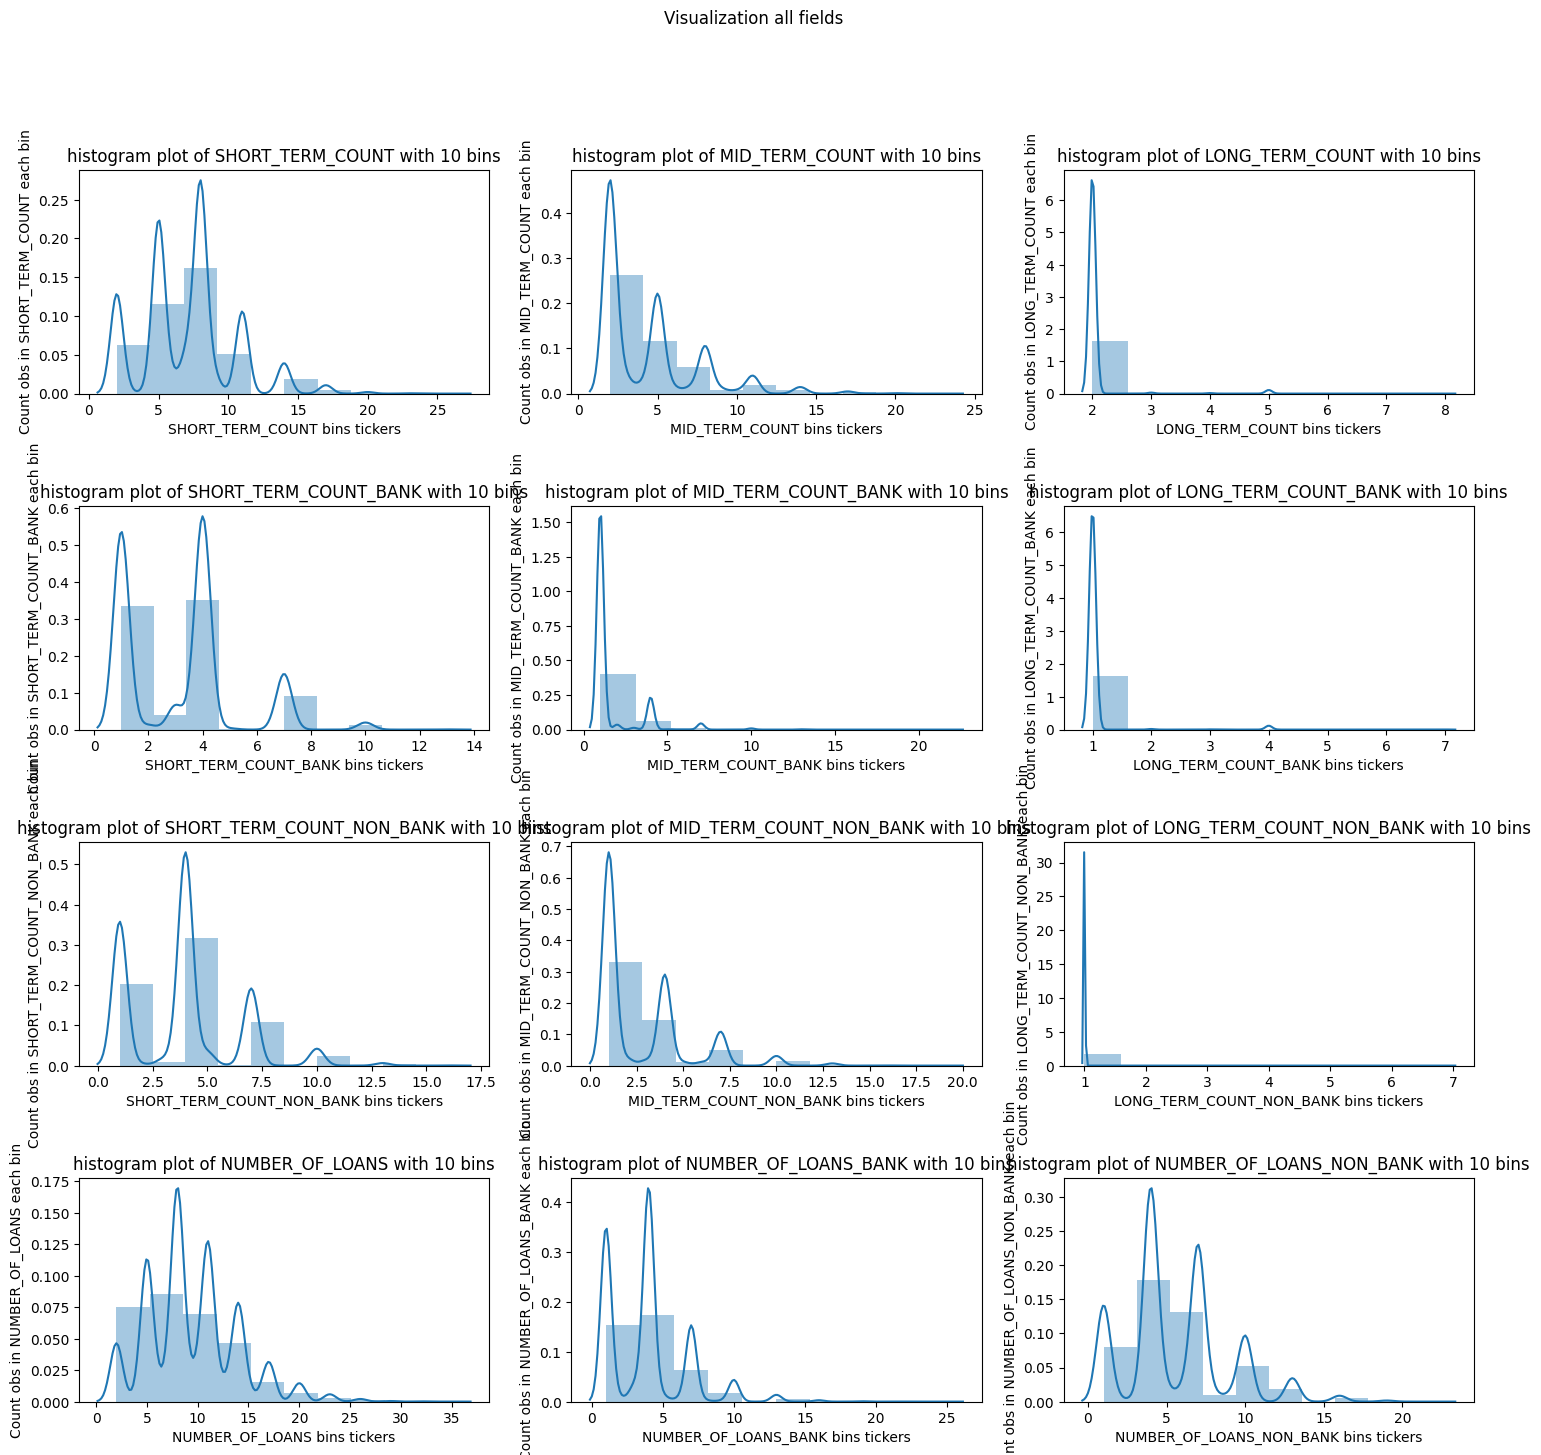

In [116]:
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins tickers'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return ax

# Biểu đồ barchart
def _plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)
  # Tạo vòng for lấy tọa độ đỉnh trên cùng của biểu đồ và thêm label thông qua annotate.
  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return ax

# Khởi tạo figure cho đồ thị (Kích thước W*H = 16x12) và cách nhau là 0.2 giữa các đồ thị
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
# Tạo vòng for check định dạng của biến và visualize
for i, (fieldname, dtype) in enumerate(zip(df.columns, df.dtypes.values)):
  if i <= 11:
    ax_i = fig.add_subplot(4, 3, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = _plot_hist_subplot(df[fieldname], fieldname=fieldname)
    else:
      ax_i = _plot_barchart_subplot(df[fieldname], fieldname=fieldname)
      
fig.suptitle('Visualization all fields')
plt.show()

In [117]:
import numpy as np
import matplotlib.pyplot as plt

MAX_VAL = 999999999
MIN_VAL = -MAX_VAL

def bin_table(data, colname, n_bins = 10, coltype = 'int64', qcut = None):
  X = data[[colname, 'label']]
  X = X.sort_values(colname)
  # coltype = X[colname].dtype
  print(coltype)
  if coltype in ['float64', 'int64']:
    if qcut is None:
      try:
        bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
        # Thay thế threshold đầu và cuối của thres
        thres[0] = MIN_VAL
        thres[-1] = MAX_VAL
        bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
        X['bins'] = bins
      except:
        print('n_bins must be lower to bin interval is valid!')
    else:
      bins, thres = pd.cut(X[colname], bins=qcut, retbins=True)
      X['bins'] = bins
  elif coltype == 'object':
    X['bins'] = X[colname]
  df_GB = pd.pivot_table(X, 
                index = ['bins'],
                values = ['label'],
                columns = ['label'],
                aggfunc = {
                    'label':np.size
                })

  df_Count = pd.pivot_table(X, 
                index = ['bins'],
                values = ['label'],
                aggfunc = {
                    'label': np.size
                })
  
  if coltype in ['float64', 'int64']:
    df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
  elif coltype == 'object':
    df_Thres = pd.DataFrame(index=df_GB.index)
    thres = None
  df_Count.columns = ['No_Obs']
  df_GB.columns = ['#BAD', '#GOOD']
  df_summary = df_Thres.join(df_Count).join(df_GB)
  return df_summary, thres

def WOE(data, colname, n_bins = None, min_obs = 100, coltype='int64', qcut = None):
  # Thống kê bins và lấy ra thres hold ban đầu
  df_summary, thres = bin_table(data, colname, n_bins = n_bins, coltype=coltype, qcut = qcut)
  # Thay thế giá trị 0 của #BAD trong df_summary bằng 1 để không bị lỗi chia cho 0
  df_summary['#BAD'] = df_summary['#BAD'].replace({0:1})
  
  if qcut is not None:
    # Lọc bỏ threshold để tạo thành threshold mới mà thỏa mãn số lượng quan sát >= min_obs
    exclude_ind = np.where(df_summary['No_Obs'] <= min_obs)[0]
    if exclude_ind.shape[0] > 0:
      new_thres = np.delete(thres, exclude_ind)
      print('Auto combine {} bins into {} bins'.format(n_bins, new_thres.shape[0]-1))
      # Tính toán lại bảng summary
      df_summary, thres = bin_table(data, colname, qcut=new_thres)
  
  new_thres = thres
  df_summary['GOOD/BAD'] = df_summary['#GOOD']/df_summary['#BAD']
  df_summary['%BAD'] = df_summary['#BAD']/df_summary['#BAD'].sum()
  df_summary['%GOOD'] = df_summary['#GOOD']/df_summary['#GOOD'].sum()
  df_summary['WOE'] = np.log(df_summary['%GOOD']/df_summary['%BAD'])
  df_summary['IV'] = (df_summary['%GOOD']-df_summary['%BAD'])*df_summary['WOE']
  df_summary['COLUMN'] = colname
  IV = df_summary['IV'].sum()
  print('Information Value of {} column: {}'.format(colname, IV))
  return df_summary, IV, new_thres

In [118]:
columns = []
IVs = []
WOE_dict=dict()

In [119]:
df['LONG_TERM_COUNT'].value_counts()

LONG_TERM_COUNT
2    19533
5      322
3       87
4       48
8       10
Name: count, dtype: int64

In [120]:
# tree = DecisionTreeClassifier(max_leaf_nodes=5)
# tree.fit(df[['LONG_TERM_COUNT']], df['label'])

# thresholds = tree.tree_.threshold[tree.tree_.threshold != -2]
# thresholds = np.sort(thresholds)

# print("Bin edges: ", thresholds)

In [121]:
# bins = np.concatenate(([-np.inf], thresholds, [np.inf]))  # Add -inf and inf for boundary values
# df['LONG_TERM_COUNT_binned'] = pd.cut(df['LONG_TERM_COUNT'], bins=bins)

In [122]:
# features = df.columns[:-1]
# features

In [123]:
def binning_and_WOE_transform(colname):

    tree = DecisionTreeClassifier(max_leaf_nodes=30)
    tree.fit(df[[colname]], df['label'])

    thresholds = tree.tree_.threshold[tree.tree_.threshold != -2]
    thresholds = np.sort(thresholds)

    bins = np.concatenate(([-np.inf], thresholds, [np.inf]))  # Add -inf and inf for boundary values
    df[f'{colname}_binned'] = pd.cut(df[colname], bins=bins)

    total_good = sum(df['label'] == 1)
    total_bad = sum(df['label'] == 0)

    # Group by bins and calculate good/bad counts in each bin
    bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
    bin_stats = bin_stats.reset_index().rename(columns={f'{colname}_binned': 'bins'}).set_index('bins')
    bin_stats.columns = ['No_Obs', 'GOOD']
    bin_stats['BAD'] = bin_stats['No_Obs'] - bin_stats['GOOD']

    # Calculate proportions for good and bad in each bin
    bin_stats['%GOOD'] = bin_stats['GOOD'] / total_good
    bin_stats['%BAD'] = bin_stats['BAD'] / total_bad

    # Calculate WOE
    bin_stats['WOE'] = np.log(bin_stats['%GOOD'] / bin_stats['%BAD'])

    # Replace infinities with a large number (handling edge cases)
    bin_stats.replace([np.inf, -np.inf], 0, inplace=True)

    bin_stats['IV'] = (bin_stats['%GOOD'] - bin_stats['%BAD']) * bin_stats['WOE']
    bin_stats['COLUMN'] = colname
    IV = bin_stats['IV'].sum()
    print(f'Information Value of {colname} column: ', IV)
    return bin_stats, IV, bins

# for col in features:
#     df_summary, IV, thres = binning_and_WOE_transform(col)
#     WOE_dict[col] = {'table':df_summary, 'IV':IV}
#     columns.append(col)
#     IVs.append(IV)

In [124]:
features = df.columns[:-1]
for col in features:
    df_summary, IV, thres = binning_and_WOE_transform(col)
    WOE_dict[col] = {'table':df_summary, 'IV':IV}
    columns.append(col)
    IVs.append(IV)

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python

Information Value of SHORT_TERM_COUNT column:  1.2094296130116204
Information Value of MID_TERM_COUNT column:  0.22058847319883892
Information Value of LONG_TERM_COUNT column:  0.011099831725829908
Information Value of SHORT_TERM_COUNT_BANK column:  0.714717568978482
Information Value of MID_TERM_COUNT_BANK column:  0.09677078394628191
Information Value of LONG_TERM_COUNT_BANK column:  0.011812866518710085
Information Value of SHORT_TERM_COUNT_NON_BANK column:  0.4760874968511582
Information Value of MID_TERM_COUNT_NON_BANK column:  0.15941678206490756
Information Value of LONG_TERM_COUNT_NON_BANK column:  6.319826417935405e-07
Information Value of NUMBER_OF_LOANS column:  3.3187624585858586
Information Value of NUMBER_OF_LOANS_BANK column:  0.7623733941174561
Information Value of NUMBER_OF_LOANS_NON_BANK column:  0.8585974077491487
Information Value of NUMBER_OF_CREDIT_CARDS column:  0.4983679050033295
Information Value of NUMBER_OF_CREDIT_CARDS_BANK column:  0.507609497329648
Informa

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python

Information Value of NUM_NEW_LOAN_TAKEN_3M column:  0.3337521607764823
Information Value of NUM_NEW_LOAN_TAKEN_6M column:  0.7529038789817756
Information Value of NUM_NEW_LOAN_TAKEN_9M column:  1.0721300668006346
Information Value of NUM_NEW_LOAN_TAKEN_12M column:  1.2414825075015272
Information Value of OUTSTANDING_BAL_LOAN_CURRENT column:  0.2682802205627218
Information Value of OUTSTANDING_BAL_LOAN_3M column:  1.5547902042569317
Information Value of OUTSTANDING_BAL_LOAN_6M column:  1.5790603690279128
Information Value of OUTSTANDING_BAL_LOAN_9M column:  1.4993020576194045
Information Value of OUTSTANDING_BAL_LOAN_12M column:  1.4071564491340105
Information Value of OUTSTANDING_BAL_CC_3M column:  0.7701671078329673
Information Value of OUTSTANDING_BAL_CC_6M column:  0.7819478682350048
Information Value of OUTSTANDING_BAL_CC_9M column:  0.773701502846585
Information Value of OUTSTANDING_BAL_CC_12M column:  0.8006752856403585


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python

Information Value of OUTSTANDING_BAL_ALL_3M column:  1.4755504764673433
Information Value of OUTSTANDING_BAL_ALL_6M column:  1.4549682516973554
Information Value of OUTSTANDING_BAL_ALL_9M column:  1.3877825018542012
Information Value of OUTSTANDING_BAL_ALL_12M column:  1.3411718957025125
Information Value of OUTSTANDING_BAL_LOAN_3M_6M column:  1.7625348390994806
Information Value of OUTSTANDING_BAL_LOAN_6M_9M column:  1.6909242288250368
Information Value of OUTSTANDING_BAL_LOAN_9M_12M column:  1.5608797157281873
Information Value of OUTSTANDING_BAL_LOAN_6M_12M column:  1.618149261273608
Information Value of OUTSTANDING_BAL_LOAN_3M_12M column:  1.672982769260482
Information Value of OUTSTANDING_BAL_CC_3M_6M column:  0.9651340985036424
Information Value of OUTSTANDING_BAL_CC_6M_9M column:  1.0331149245478708
Information Value of OUTSTANDING_BAL_CC_9M_12M column:  1.0124507392503852
Information Value of OUTSTANDING_BAL_CC_6M_12M column:  1.013396590959008


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python

Information Value of OUTSTANDING_BAL_CC_3M_12M column:  0.9300957949581692
Information Value of OUTSTANDING_BAL_ALL_3M_6M column:  1.544772241274694
Information Value of OUTSTANDING_BAL_ALL_6M_9M column:  1.4501752392217064
Information Value of OUTSTANDING_BAL_ALL_9M_12M column:  1.3808427494150468
Information Value of OUTSTANDING_BAL_ALL_6M_12M column:  1.4050907596558964
Information Value of OUTSTANDING_BAL_ALL_3M_12M column:  1.4392239229541652
Information Value of INCREASING_BAL_3M_LOAN column:  0.06007592126062844
Information Value of INCREASING_BAL_6M_LOAN column:  0.2784799608600051
Information Value of INCREASING_BAL_3M_CC column:  0.1838057194764266
Information Value of INCREASING_BAL_6M_CC column:  0.338781705419925
Information Value of INCREASING_BAL_3M_ALL column:  0.048681536069727624
Information Value of INCREASING_BAL_6M_ALL column:  0.22506688179076131
Information Value of OUTSTANDING_BAL_CC_CURRENT column:  0.6894769909367905
Information Value of ENQUIRIES_3M column:  

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python

Information Value of ENQUIRIES_9M column:  0.08970960981069558
Information Value of ENQUIRIES_12M column:  0.11534360831262998
Information Value of ENQUIRIES_FROM_BANK_3M column:  0.04393245587791895
Information Value of ENQUIRIES_FROM_NON_BANK_3M column:  0.06029443310492541
Information Value of ENQUIRIES_FOR_LOAN_3M column:  0.022747061668753784
Information Value of ENQUIRIES_FOR_CC_3M column:  0.023215620313852
Information Value of ENQUIRIES_FROM_BANK_FOR_LOAN_3M column:  0.042433466800735786
Information Value of ENQUIRIES_FROM_NON_BANK_FOR_LOAN_3M column:  0.05146453811990148
Information Value of ENQUIRIES_FROM_BANK_FOR_CC_3M column:  0.02644016290376881
Information Value of ENQUIRIES_FROM_NON_BANK_FOR_CC_3M column:  0.002271920092417303
Information Value of ENQUIRIES_FROM_BANK_6M column:  0.07401784163978223
Information Value of ENQUIRIES_FROM_NON_BANK_6M column:  0.061284441920077676
Information Value of ENQUIRIES_FOR_LOAN_6M column:  0.05152999519611851
Information Value of ENQU

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

Information Value of ENQUIRIES_FROM_NON_BANK_9M column:  0.059745084287513635
Information Value of ENQUIRIES_FOR_LOAN_9M column:  0.08531329842997482
Information Value of ENQUIRIES_FOR_CC_9M column:  0.08273494772492816
Information Value of ENQUIRIES_FROM_BANK_FOR_LOAN_9M column:  0.102294281760584
Information Value of ENQUIRIES_FROM_NON_BANK_FOR_LOAN_9M column:  0.04653056922091058
Information Value of ENQUIRIES_FROM_BANK_FOR_CC_9M column:  0.09391976182521787
Information Value of ENQUIRIES_FROM_NON_BANK_FOR_CC_9M column:  0.019427357997489545
Information Value of ENQUIRIES_FROM_BANK_12M column:  0.1423261653412462
Information Value of ENQUIRIES_FROM_NON_BANK_12M column:  0.04185661179458587
Information Value of ENQUIRIES_FOR_LOAN_12M column:  0.10825018367525188
Information Value of ENQUIRIES_FOR_CC_12M column:  0.1054572008054588
Information Value of ENQUIRIES_FROM_BANK_FOR_LOAN_12M column:  0.13457767622095912
Information Value of ENQUIRIES_FROM_NON_BANK_FOR_LOAN_12M column:  0.048

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tr

In [24]:
# df_summary, IV, thres = WOE(df, 'LONG_TERM_COUNT', n_bins = 4, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('LONG_TERM_COUNT')
df_summary.fillna(0, inplace=True)
columns.append('LONG_TERM_COUNT')
IVs.append(IV)
WOE_dict['LONG_TERM_COUNT'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of LONG_TERM_COUNT column:  0.011099831725829908


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",19533,3608,15925,0.990121,0.973649,0.016776,0.000276,LONG_TERM_COUNT
"(2.5, 3.5]",87,8,79,0.002195,0.004830,-0.788493,0.002077,LONG_TERM_COUNT
"(3.5, 4.5]",48,0,48,0.000000,0.002935,0.000000,-0.000000,LONG_TERM_COUNT
"(4.5, 6.5]",322,28,294,0.007684,0.017975,-0.849862,0.008746,LONG_TERM_COUNT
"(6.5, inf]",10,0,10,0.000000,0.000611,0.000000,-0.000000,LONG_TERM_COUNT


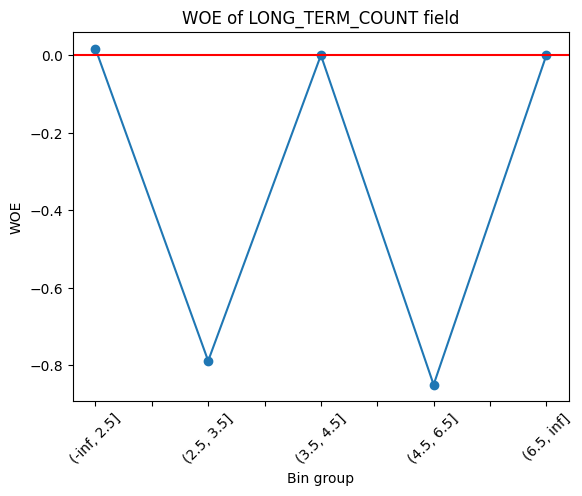

In [25]:
def _plot(df_summary):
  colname = list(df_summary['COLUMN'].unique())[0]
  df_summary['WOE'].plot(linestyle='-', marker='o')
  plt.title('WOE of {} field'.format(colname))
  plt.axhline(y=0, color = 'red')
  plt.xticks(rotation=45)
  plt.ylabel('WOE')
  plt.xlabel('Bin group')

_plot(df_summary) 

In [26]:
# df_summary, IV, thres = WOE(df, 'MID_TERM_COUNT_BANK', n_bins = 4, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('MID_TERM_COUNT_BANK')
df_summary.fillna(0, inplace=True)
columns.append('MID_TERM_COUNT_BANK')
IVs.append(IV)
WOE_dict['MID_TERM_COUNT_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of MID_TERM_COUNT_BANK column:  0.09677078394628191


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 1.5]",16452,3314,13138,0.909440,0.803253,0.124160,0.013184,MID_TERM_COUNT_BANK
"(1.5, 2.5]",372,49,323,0.013447,0.019748,-0.384319,0.002422,MID_TERM_COUNT_BANK
"(2.5, 3.5]",134,14,120,0.003842,0.007337,-0.646922,0.002261,MID_TERM_COUNT_BANK
"(3.5, 4.5]",2431,230,2201,0.063117,0.134568,-0.757075,0.054094,MID_TERM_COUNT_BANK
"(4.5, 6.0]",26,0,26,0.000000,0.001590,0.000000,-0.000000,MID_TERM_COUNT_BANK
"(6.0, 8.5]",468,31,437,0.008507,0.026718,-1.144433,0.020841,MID_TERM_COUNT_BANK
"(8.5, 11.5]",90,6,84,0.001647,0.005136,-1.137545,0.003969,MID_TERM_COUNT_BANK
"(11.5, inf]",27,0,27,0.000000,0.001651,0.000000,-0.000000,MID_TERM_COUNT_BANK


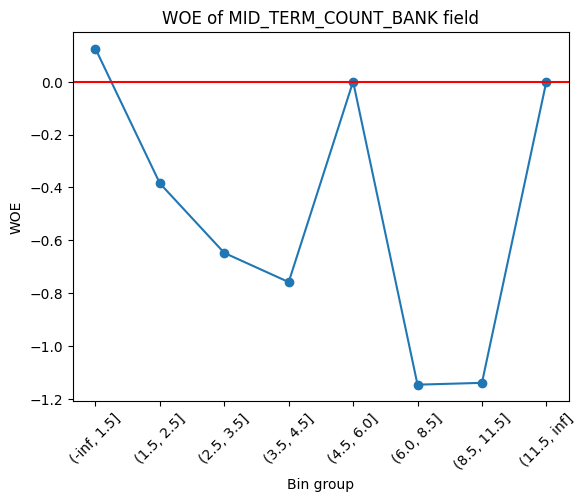

In [27]:
_plot(df_summary) 

In [28]:
# df_summary, IV, thres = WOE(df, 'SHORT_TERM_COUNT_NON_BANK', n_bins = 4, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('SHORT_TERM_COUNT_NON_BANK')
df_summary.fillna(0, inplace=True)
columns.append('SHORT_TERM_COUNT_NON_BANK')
IVs.append(IV)
WOE_dict['SHORT_TERM_COUNT_NON_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of SHORT_TERM_COUNT_NON_BANK column:  0.4760874968511582


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 1.5]",6053,2043,4010,0.560648,0.245170,0.827141,0.260944,SHORT_TERM_COUNT_NON_BANK
"(1.5, 2.5]",66,28,38,0.007684,0.002323,1.196131,0.006412,SHORT_TERM_COUNT_NON_BANK
"(2.5, 3.5]",277,66,211,0.018112,0.012900,0.339309,0.001768,SHORT_TERM_COUNT_NON_BANK
"(3.5, 4.5]",8962,1097,7865,0.301043,0.480863,-0.468331,0.084215,SHORT_TERM_COUNT_NON_BANK
"(4.5, 5.5]",554,54,500,0.014819,0.030570,-0.724111,0.011405,SHORT_TERM_COUNT_NON_BANK
"(5.5, 6.5]",20,3,17,0.000823,0.001039,-0.233088,0.000050,SHORT_TERM_COUNT_NON_BANK
"(6.5, 8.5]",3245,277,2968,0.076015,0.181462,-0.870113,0.091751,SHORT_TERM_COUNT_NON_BANK
"(8.5, 11.5]",711,65,646,0.017838,0.039496,-0.794899,0.017216,SHORT_TERM_COUNT_NON_BANK
"(11.5, 14.5]",105,10,95,0.002744,0.005808,-0.749779,0.002297,SHORT_TERM_COUNT_NON_BANK


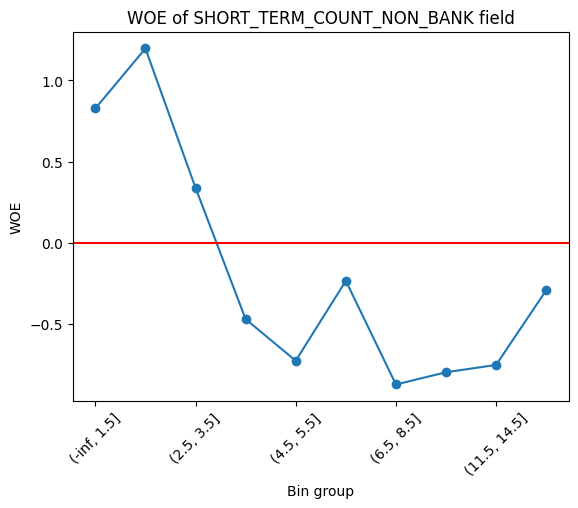

In [29]:
_plot(df_summary)

In [30]:
# df_summary, IV, thres = WOE(df, 'LONG_TERM_COUNT_NON_BANK', n_bins = 4, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('LONG_TERM_COUNT_NON_BANK')
df_summary.fillna(0, inplace=True)
columns.append('LONG_TERM_COUNT_NON_BANK')
IVs.append(IV)
WOE_dict['LONG_TERM_COUNT_NON_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of LONG_TERM_COUNT_NON_BANK column:  6.319826417935405e-07


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",19987,3644,16343,1.0,0.999205,0.000795,6.319826e-07,LONG_TERM_COUNT_NON_BANK
"(2.5, inf]",13,0,13,0.0,0.000795,0.000000,-0.000000e+00,LONG_TERM_COUNT_NON_BANK


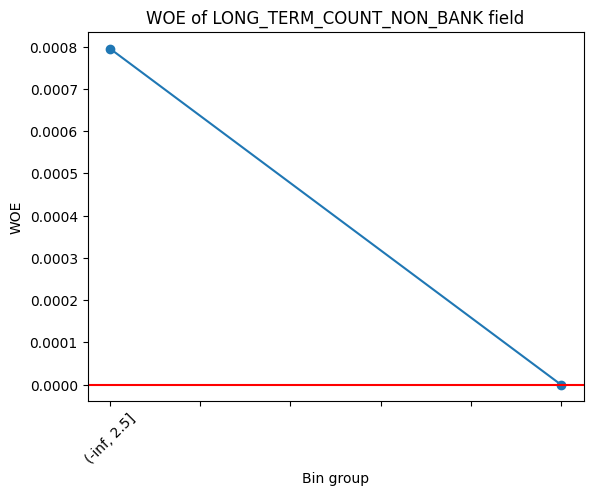

In [31]:
_plot(df_summary)

In [32]:
# df_summary, IV, thres = WOE(df, 'NUMBER_OF_LOANS', n_bins = 4, min_obs= 100, coltype='int64')
df_summary, IV, thres = binning_and_WOE_transform('NUMBER_OF_LOANS')
df_summary.fillna(0, inplace=True)
columns.append('NUMBER_OF_LOANS')
IVs.append(IV)
WOE_dict['NUMBER_OF_LOANS'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of NUMBER_OF_LOANS column:  3.3187624585858586


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",1427,1424,3,0.390779,0.000183,7.664126,2.993576,NUMBER_OF_LOANS
"(2.5, 4.5]",70,70,0,0.019210,0.000000,0.000000,0.000000,NUMBER_OF_LOANS
"(4.5, 5.5]",3446,631,2815,0.173161,0.172108,0.006101,0.000006,NUMBER_OF_LOANS
"(5.5, 6.5]",222,40,182,0.010977,0.011127,-0.013614,0.000002,NUMBER_OF_LOANS
"(6.5, 7.5]",385,63,322,0.017289,0.019687,-0.129904,0.000312,NUMBER_OF_LOANS
"(7.5, 8.5]",5059,608,4451,0.166850,0.272133,-0.489196,0.051504,NUMBER_OF_LOANS
"(8.5, 9.5]",434,61,373,0.016740,0.022805,-0.309192,0.001875,NUMBER_OF_LOANS
"(9.5, 10.5]",428,47,381,0.012898,0.023294,-0.591139,0.006146,NUMBER_OF_LOANS
"(10.5, 11.5]",3748,382,3366,0.104830,0.205796,-0.674547,0.068106,NUMBER_OF_LOANS


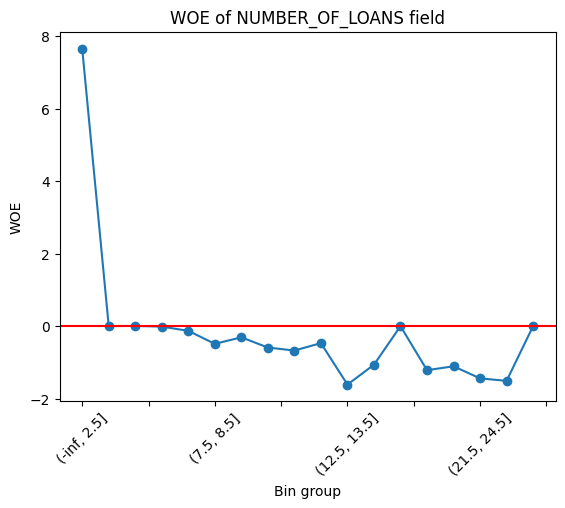

In [33]:
_plot(df_summary)

In [34]:
# df_summary, IV, thres = WOE(df, 'NUMBER_OF_CREDIT_CARDS', n_bins = 3, min_obs= 100, coltype='int64')
df_summary, IV, thres = binning_and_WOE_transform('NUMBER_OF_CREDIT_CARDS')
df_summary.fillna(0, inplace=True)
columns.append('NUMBER_OF_CREDIT_CARDS')
IVs.append(IV)
WOE_dict['NUMBER_OF_CREDIT_CARDS'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of NUMBER_OF_CREDIT_CARDS column:  0.4983679050033295


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",6089,1991,4098,0.546378,0.250550,0.779651,0.230642,NUMBER_OF_CREDIT_CARDS
"(2.5, 3.5]",846,158,688,0.043359,0.042064,0.030319,0.000039,NUMBER_OF_CREDIT_CARDS
"(3.5, 4.5]",450,35,415,0.009605,0.025373,-0.971418,0.015317,NUMBER_OF_CREDIT_CARDS
"(4.5, 5.5]",5679,874,4805,0.239846,0.293776,-0.202819,0.010938,NUMBER_OF_CREDIT_CARDS
"(5.5, 6.5]",266,56,210,0.015368,0.012839,0.179757,0.000454,NUMBER_OF_CREDIT_CARDS
"(6.5, 7.5]",325,44,281,0.012075,0.017180,-0.352652,0.001800,NUMBER_OF_CREDIT_CARDS
"(7.5, 8.5]",2700,274,2426,0.075192,0.148325,-0.679358,0.049683,NUMBER_OF_CREDIT_CARDS
"(8.5, 9.5]",215,13,202,0.003568,0.012350,-1.241806,0.010906,NUMBER_OF_CREDIT_CARDS
"(9.5, 10.5]",180,4,176,0.001098,0.010761,-2.282677,0.022057,NUMBER_OF_CREDIT_CARDS


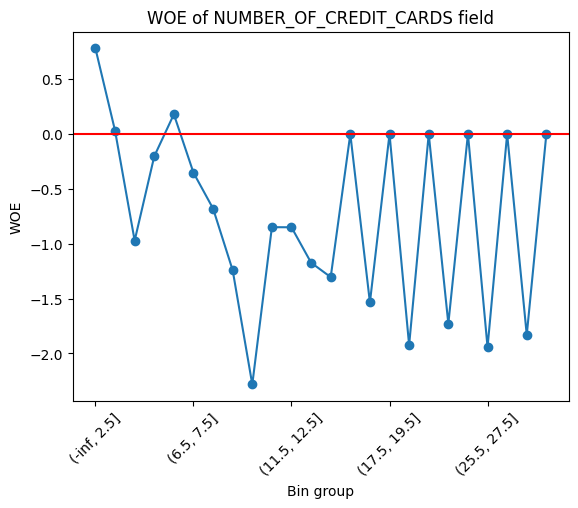

In [35]:
_plot(df_summary)

In [36]:
# df_summary, IV, thres = WOE(df, 'NUMBER_OF_CREDIT_CARDS_NON_BANK', n_bins = 2, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('NUMBER_OF_CREDIT_CARDS_NON_BANK')
df_summary.fillna(0, inplace=True)
columns.append('NUMBER_OF_CREDIT_CARDS_NON_BANK')
IVs.append(IV)
WOE_dict['NUMBER_OF_CREDIT_CARDS_NON_BANK'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of NUMBER_OF_CREDIT_CARDS_NON_BANK column:  0.05824511907199123


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 1.5]",12945,2660,10285,0.729967,0.628821,0.149152,0.015086,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(1.5, 2.5]",333,42,291,0.011526,0.017792,-0.434141,0.002720,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(2.5, 3.5]",451,32,419,0.008782,0.025618,-1.070622,0.018025,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(3.5, 4.5]",5222,760,4462,0.208562,0.272805,-0.268521,0.017251,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(4.5, 6.0]",7,7,0,0.001921,0.000000,0.000000,0.000000,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(6.0, 8.5]",893,124,769,0.034029,0.047016,-0.323297,0.004199,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(8.5, 11.5]",112,17,95,0.004665,0.005808,-0.219151,0.000251,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(11.5, 14.5]",24,2,22,0.000549,0.001345,-0.896382,0.000714,NUMBER_OF_CREDIT_CARDS_NON_BANK
"(14.5, inf]",13,0,13,0.000000,0.000795,0.000000,-0.000000,NUMBER_OF_CREDIT_CARDS_NON_BANK


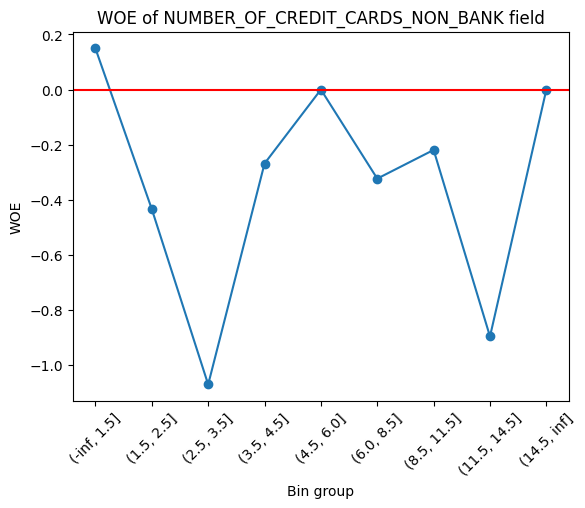

In [37]:
_plot(df_summary)

In [38]:
# df_summary, IV, thres = WOE(df, 'NUM_NEW_LOAN_TAKEN_3M', n_bins = 4, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('NUM_NEW_LOAN_TAKEN_3M')
df_summary.fillna(0, inplace=True)
columns.append('NUM_NEW_LOAN_TAKEN_3M')
IVs.append(IV)
WOE_dict['NUM_NEW_LOAN_TAKEN_3M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of NUM_NEW_LOAN_TAKEN_3M column:  0.3337521607764823


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 1.5]",7695,2236,5459,0.613611,0.333761,0.608936,0.170411,NUM_NEW_LOAN_TAKEN_3M
"(1.5, 2.5]",191,45,146,0.012349,0.008926,0.324569,0.001111,NUM_NEW_LOAN_TAKEN_3M
"(2.5, 3.5]",488,66,422,0.018112,0.025801,-0.353838,0.002721,NUM_NEW_LOAN_TAKEN_3M
"(3.5, 4.5]",7021,802,6219,0.220088,0.380227,-0.546743,0.087555,NUM_NEW_LOAN_TAKEN_3M
"(4.5, 5.5]",310,42,268,0.011526,0.016385,-0.351805,0.001710,NUM_NEW_LOAN_TAKEN_3M
"(5.5, 6.5]",110,12,98,0.003293,0.005992,-0.598548,0.001615,NUM_NEW_LOAN_TAKEN_3M
"(6.5, 8.5]",2980,317,2663,0.086992,0.162815,-0.626794,0.047525,NUM_NEW_LOAN_TAKEN_3M
"(8.5, 11.5]",941,98,843,0.026894,0.051541,-0.650487,0.016033,NUM_NEW_LOAN_TAKEN_3M
"(11.5, 14.5]",204,21,183,0.005763,0.011189,-0.663451,0.003600,NUM_NEW_LOAN_TAKEN_3M


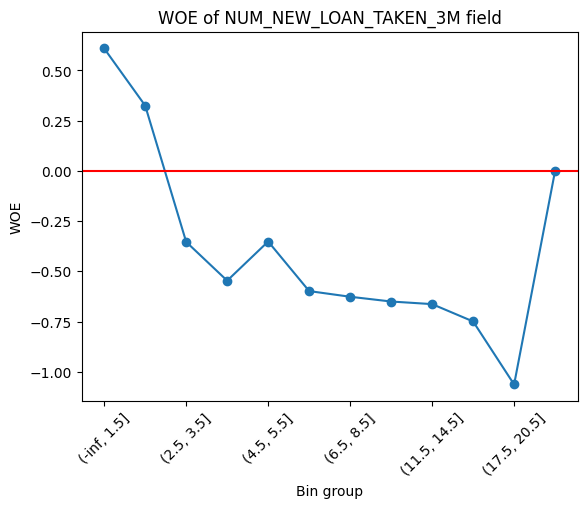

In [39]:
_plot(df_summary)

In [40]:
# df_summary, IV, thres = WOE(df, 'OUTSTANDING_BAL_ALL_3M', n_bins = 10, min_obs= 100, coltype='int64')
df_summary, IV, thres = binning_and_WOE_transform('OUTSTANDING_BAL_ALL_3M')
df_summary.fillna(0, inplace=True)
columns.append('OUTSTANDING_BAL_ALL_3M')
IVs.append(IV)
WOE_dict['OUTSTANDING_BAL_ALL_3M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of OUTSTANDING_BAL_ALL_3M column:  1.4755504764673433


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 1000003.094]",1310,1180,130,0.323820,0.007948,3.707248,1.171015,OUTSTANDING_BAL_ALL_3M
"(1000003.094, 1000004.594]",142,72,70,0.019759,0.004280,1.529684,0.023678,OUTSTANDING_BAL_ALL_3M
"(1000004.594, 1000005.0]",3,3,0,0.000823,0.000000,0.000000,0.000000,OUTSTANDING_BAL_ALL_3M
"(1000005.0, 1000006.5]",4,0,4,0.000000,0.000245,0.000000,-0.000000,OUTSTANDING_BAL_ALL_3M
"(1000006.5, 1000006.781]",177,63,114,0.017289,0.006970,0.908449,0.009374,OUTSTANDING_BAL_ALL_3M
"(1000006.781, 1000008.812]",11,10,1,0.002744,0.000061,3.804098,0.010207,OUTSTANDING_BAL_ALL_3M
"(1000008.812, 1000009.906]",13,1,12,0.000274,0.000734,-0.983394,0.000452,OUTSTANDING_BAL_ALL_3M
"(1000009.906, 1000014.062]",311,94,217,0.025796,0.013267,0.664910,0.008330,OUTSTANDING_BAL_ALL_3M
"(1000014.062, 1000014.594]",1,1,0,0.000274,0.000000,0.000000,0.000000,OUTSTANDING_BAL_ALL_3M


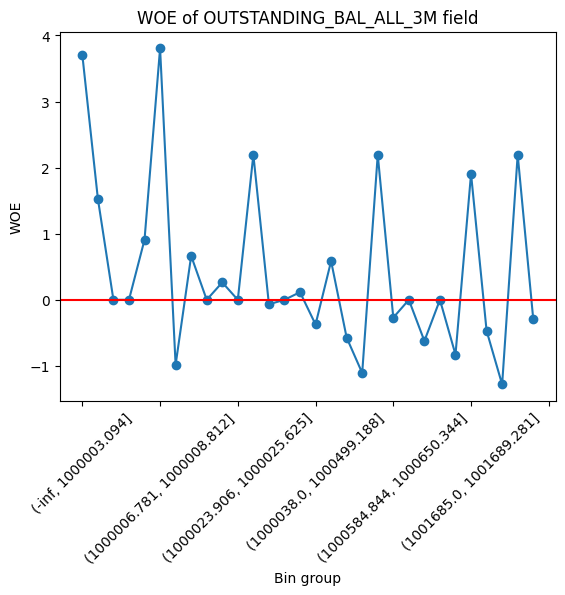

In [41]:
_plot(df_summary)

In [42]:
# df_summary, IV, thres = WOE(df, 'OUTSTANDING_BAL_LOAN_9M_12M', n_bins = 3, min_obs= 100, coltype='int64')
df_summary, IV, thres = binning_and_WOE_transform('OUTSTANDING_BAL_LOAN_9M_12M')
df_summary.fillna(0, inplace=True)
columns.append('OUTSTANDING_BAL_LOAN_9M_12M')
IVs.append(IV)
WOE_dict['OUTSTANDING_BAL_LOAN_9M_12M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of OUTSTANDING_BAL_LOAN_9M_12M column:  1.5608797157281873


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 999995.0]",38,11,27,0.003019,0.001651,0.603571,0.000826,OUTSTANDING_BAL_LOAN_9M_12M
"(999995.0, 1000000.531]",1252,1153,99,0.316411,0.006053,3.956515,1.227935,OUTSTANDING_BAL_LOAN_9M_12M
"(1000000.531, 1000000.656]",5,2,3,0.000549,0.000183,1.096048,0.000401,OUTSTANDING_BAL_LOAN_9M_12M
"(1000000.656, 1000000.844]",4,0,4,0.000000,0.000245,0.000000,-0.000000,OUTSTANDING_BAL_LOAN_9M_12M
"(1000000.844, 1000001.25]",9,6,3,0.001647,0.000183,2.194660,0.003211,OUTSTANDING_BAL_LOAN_9M_12M
"(1000001.25, 1000001.719]",26,24,2,0.006586,0.000122,3.986419,0.025768,OUTSTANDING_BAL_LOAN_9M_12M
"(1000001.719, 1000001.906]",6,3,3,0.000823,0.000183,1.501513,0.000961,OUTSTANDING_BAL_LOAN_9M_12M
"(1000001.906, 1000002.219]",8,0,8,0.000000,0.000489,0.000000,-0.000000,OUTSTANDING_BAL_LOAN_9M_12M
"(1000002.219, 1000002.281]",5,4,1,0.001098,0.000061,2.887807,0.002993,OUTSTANDING_BAL_LOAN_9M_12M


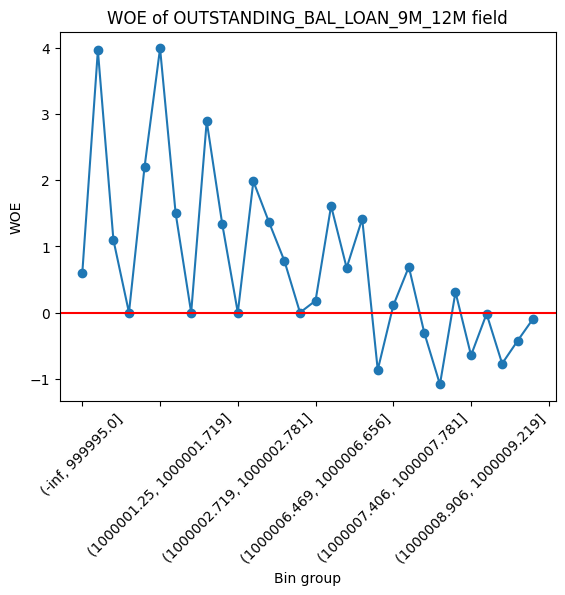

In [43]:
_plot(df_summary)

In [44]:
# df_summary, IV, thres = WOE(df, 'INCREASING_BAL_6M_LOAN', n_bins = 5, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('INCREASING_BAL_6M_LOAN')
df_summary.fillna(0, inplace=True)
columns.append('INCREASING_BAL_6M_LOAN')
IVs.append(IV)
WOE_dict['INCREASING_BAL_6M_LOAN'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of INCREASING_BAL_6M_LOAN column:  0.2784799608600051


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 1000000.031]",18401,3092,15309,0.848518,0.935987,-0.098110,0.008582,INCREASING_BAL_6M_LOAN
"(1000000.031, 1000000.125]",386,0,386,0.000000,0.023600,0.000000,-0.000000,INCREASING_BAL_6M_LOAN
"(1000000.125, 1000000.219]",284,62,222,0.017014,0.013573,0.225970,0.000778,INCREASING_BAL_6M_LOAN
"(1000000.219, 1000000.281]",143,0,143,0.000000,0.008743,0.000000,-0.000000,INCREASING_BAL_6M_LOAN
"(1000000.281, 1000000.344]",116,53,63,0.014544,0.003852,1.328670,0.014207,INCREASING_BAL_6M_LOAN
"(1000000.344, 1000000.438]",39,0,39,0.000000,0.002384,0.000000,-0.000000,INCREASING_BAL_6M_LOAN
"(1000000.438, 1000000.531]",33,18,15,0.004940,0.000917,1.683834,0.006773,INCREASING_BAL_6M_LOAN
"(1000000.531, 1000000.656]",14,0,14,0.000000,0.000856,0.000000,-0.000000,INCREASING_BAL_6M_LOAN
"(1000000.656, 1000000.75]",6,3,3,0.000823,0.000183,1.501513,0.000961,INCREASING_BAL_6M_LOAN


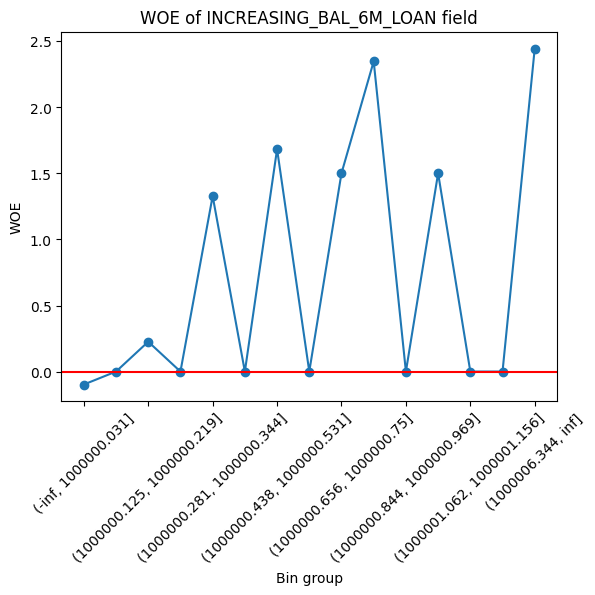

In [45]:
_plot(df_summary)

In [46]:
# df_summary, IV, thres = WOE(df, 'INCREASING_BAL_6M_CC', n_bins = 2, min_obs= 500, coltype='int64')
df_summary, IV, thres = binning_and_WOE_transform('INCREASING_BAL_6M_CC')
df_summary.fillna(0, inplace=True)
columns.append('INCREASING_BAL_6M_CC')
IVs.append(IV)
WOE_dict['INCREASING_BAL_6M_CC'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of INCREASING_BAL_6M_CC column:  0.338781705419925


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 999990.188]",3689,416,3273,0.114160,0.200110,-0.561264,0.048241,INCREASING_BAL_6M_CC
"(999990.188, 999993.969]",228,5,223,0.001372,0.013634,-2.296221,0.028156,INCREASING_BAL_6M_CC
"(999993.969, 999996.656]",388,55,333,0.015093,0.020360,-0.299296,0.001576,INCREASING_BAL_6M_CC
"(999996.656, 999996.719]",18,6,12,0.001647,0.000734,0.808366,0.000738,INCREASING_BAL_6M_CC
"(999996.719, 999996.781]",9,0,9,0.000000,0.000550,0.000000,-0.000000,INCREASING_BAL_6M_CC
"(999996.781, 999996.844]",7,7,0,0.001921,0.000000,0.000000,0.000000,INCREASING_BAL_6M_CC
"(999996.844, 999996.969]",14,0,14,0.000000,0.000856,0.000000,-0.000000,INCREASING_BAL_6M_CC
"(999996.969, 999997.031]",7,3,4,0.000823,0.000245,1.213831,0.000702,INCREASING_BAL_6M_CC
"(999997.031, 999997.281]",29,3,26,0.000823,0.001590,-0.657971,0.000504,INCREASING_BAL_6M_CC


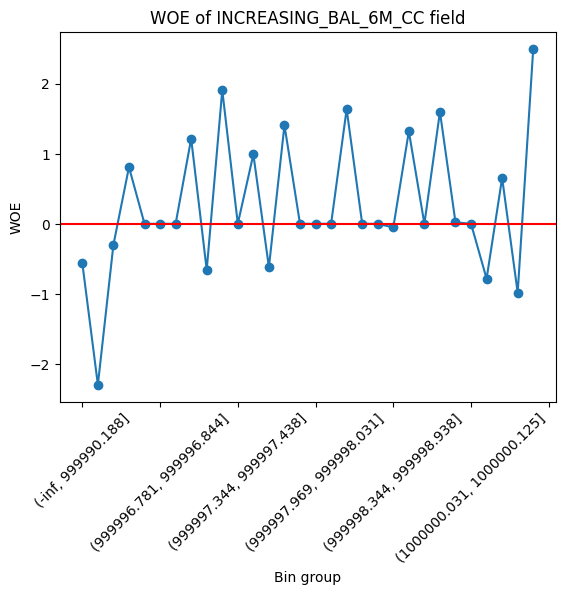

In [47]:
_plot(df_summary)

In [48]:
# df_summary, IV, thres = WOE(df, 'INCREASING_BAL_3M_ALL', n_bins = 4, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('INCREASING_BAL_3M_ALL')
df_summary.fillna(0, inplace=True)
columns.append('INCREASING_BAL_3M_ALL')
IVs.append(IV)
WOE_dict['INCREASING_BAL_3M_ALL'] = {'table':df_summary, 'IV':IV}
df_summary

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])


Information Value of INCREASING_BAL_3M_ALL column:  0.048681536069727624


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 1000000.031]",15571,2726,12845,0.748079,0.785339,-0.048606,0.001811,INCREASING_BAL_3M_ALL
"(1000000.031, 1000000.125]",26,0,26,0.000000,0.001590,0.000000,-0.000000,INCREASING_BAL_3M_ALL
"(1000000.125, 1000000.219]",52,21,31,0.005763,0.001895,1.112048,0.004301,INCREASING_BAL_3M_ALL
"(1000000.219, 1000000.281]",29,0,29,0.000000,0.001773,0.000000,-0.000000,INCREASING_BAL_3M_ALL
"(1000000.281, 1000000.344]",41,8,33,0.002195,0.002018,0.084447,0.000015,INCREASING_BAL_3M_ALL
"(1000000.344, 1000000.438]",31,0,31,0.000000,0.001895,0.000000,-0.000000,INCREASING_BAL_3M_ALL
"(1000000.438, 1000000.531]",51,5,46,0.001372,0.002812,-0.717691,0.001034,INCREASING_BAL_3M_ALL
"(1000000.531, 1000000.656]",99,0,99,0.000000,0.006053,0.000000,-0.000000,INCREASING_BAL_3M_ALL
"(1000000.656, 1000000.844]",149,35,114,0.009605,0.006970,0.320662,0.000845,INCREASING_BAL_3M_ALL


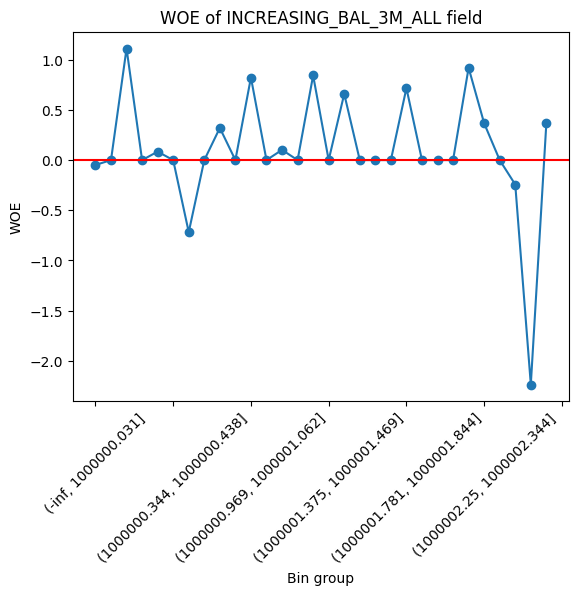

In [49]:
_plot(df_summary)

In [50]:
# df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M', n_bins = 3, min_obs= 100, coltype='int64')
df_summary, IV, thres = binning_and_WOE_transform('ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M column:  0.04552808961124355


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 4.5]",347,347,0,0.095225,0.000000,0.000000,0.000000e+00,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(4.5, 7.5]",8377,1519,6858,0.416850,0.419296,-0.005851,1.431140e-05,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(7.5, 8.5]",141,23,118,0.006312,0.007214,-0.133678,1.206751e-04,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(8.5, 9.5]",306,46,260,0.012623,0.015896,-0.230527,7.544739e-04,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(9.5, 10.5]",325,55,270,0.015093,0.016508,-0.089576,1.266962e-04,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(10.5, 11.5]",446,52,394,0.014270,0.024089,-0.523594,5.141166e-03,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(11.5, 12.5]",6283,958,5325,0.262898,0.325569,-0.213807,1.339946e-02,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(12.5, 13.5]",201,48,153,0.013172,0.009354,0.342276,1.306800e-03,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M
"(13.5, 14.5]",50,28,22,0.007684,0.001345,1.742675,1.104645e-02,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M


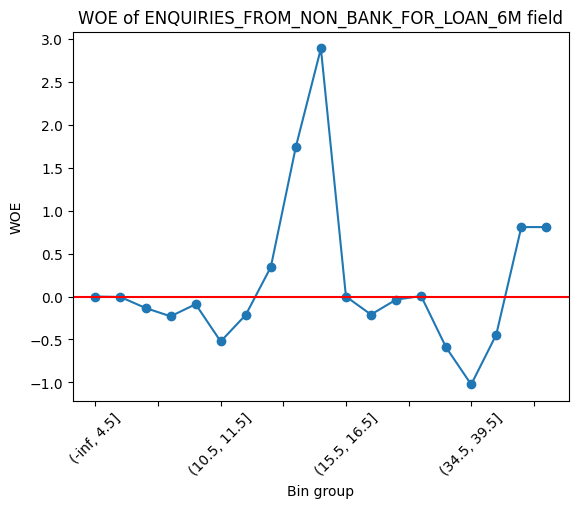

In [51]:
_plot(df_summary)

In [52]:
# df_summary, IV, thres = WOE(df, 'ENQUIRIES_FOR_LOAN_12M', n_bins = 5, min_obs= 100, coltype='int64')
df_summary, IV, thres = binning_and_WOE_transform('ENQUIRIES_FOR_LOAN_12M')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FOR_LOAN_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FOR_LOAN_12M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of ENQUIRIES_FOR_LOAN_12M column:  0.10825018367525188


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 4.5]",347,347,0,0.095225,0.000000,0.000000,0.000000,ENQUIRIES_FOR_LOAN_12M
"(4.5, 7.5]",4569,971,3598,0.266465,0.219980,0.191706,0.008911,ENQUIRIES_FOR_LOAN_12M
"(7.5, 8.5]",31,2,29,0.000549,0.001773,-1.172636,0.001436,ENQUIRIES_FOR_LOAN_12M
"(8.5, 10.5]",334,54,280,0.014819,0.017119,-0.144293,0.000332,ENQUIRIES_FOR_LOAN_12M
"(10.5, 12.5]",4197,794,3403,0.217892,0.208058,0.046184,0.000454,ENQUIRIES_FOR_LOAN_12M
"(12.5, 14.5]",176,41,135,0.011251,0.008254,0.309810,0.000929,ENQUIRIES_FOR_LOAN_12M
"(14.5, 16.5]",169,34,135,0.009330,0.008254,0.122599,0.000132,ENQUIRIES_FOR_LOAN_12M
"(16.5, 18.5]",2861,506,2355,0.138858,0.143984,-0.036247,0.000186,ENQUIRIES_FOR_LOAN_12M
"(18.5, 21.5]",167,16,151,0.004391,0.009232,-0.743178,0.003598,ENQUIRIES_FOR_LOAN_12M


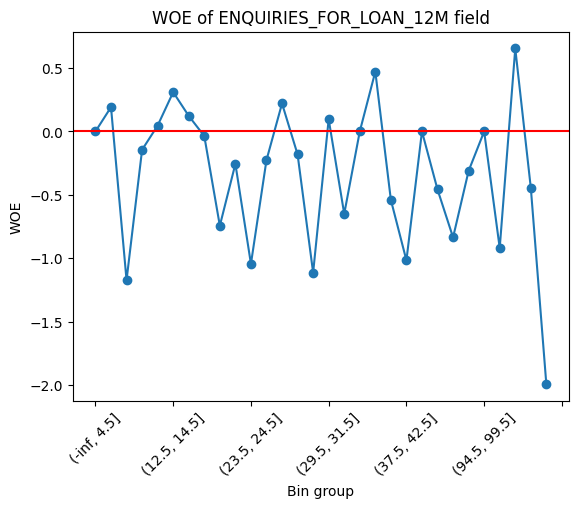

In [53]:
_plot(df_summary)

In [54]:
# df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_NON_BANK_FOR_CC_12M', n_bins = 2, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('ENQUIRIES_FROM_NON_BANK_FOR_CC_12M')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_NON_BANK_FOR_CC_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_NON_BANK_FOR_CC_12M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of ENQUIRIES_FROM_NON_BANK_FOR_CC_12M column:  0.007817619350137564


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",16743,3090,13653,0.847969,0.834740,0.015725,0.000208,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(2.5, 3.5]",458,88,370,0.024149,0.022622,0.065347,0.000100,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(3.5, 4.5]",346,37,309,0.010154,0.018892,-0.620911,0.005426,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(4.5, 5.5]",110,17,93,0.004665,0.005686,-0.197873,0.000202,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(5.5, 6.5]",5,5,0,0.001372,0.000000,0.000000,0.000000,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(6.5, 9.5]",1664,301,1363,0.082602,0.083333,-0.008820,0.000006,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(9.5, 14.5]",469,80,389,0.021954,0.023783,-0.080040,0.000146,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(14.5, 19.5]",130,16,114,0.004391,0.006970,-0.462097,0.001192,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M
"(19.5, 24.5]",43,7,36,0.001921,0.002201,-0.136096,0.000038,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M


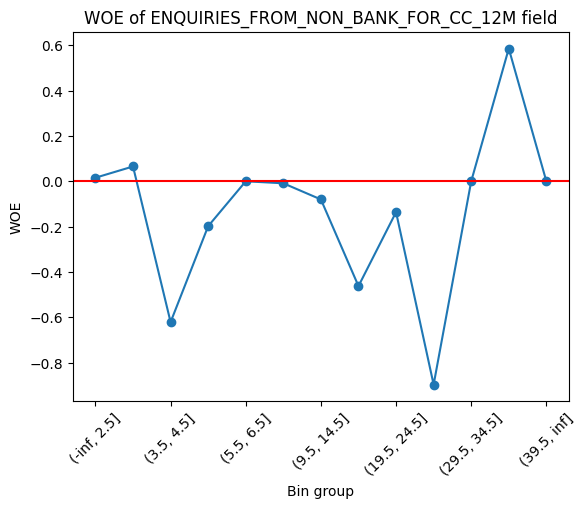

In [55]:
_plot(df_summary)

In [56]:
# df_summary, IV, thres = WOE(df, 'ENQUIRIES_6M_9M', n_bins = 2, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('ENQUIRIES_6M_9M')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_6M_9M')
IVs.append(IV)
WOE_dict['ENQUIRIES_6M_9M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of ENQUIRIES_6M_9M column:  0.6738618828918407


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",351,347,4,0.095225,0.000245,5.964543,0.566515,ENQUIRIES_6M_9M
"(2.5, 3.5]",376,39,337,0.010703,0.020604,-0.655008,0.006486,ENQUIRIES_6M_9M
"(3.5, 4.5]",735,73,662,0.020033,0.040474,-0.703293,0.014376,ENQUIRIES_6M_9M
"(4.5, 5.5]",2137,214,1923,0.058727,0.117572,-0.694153,0.040847,ENQUIRIES_6M_9M
"(5.5, 6.5]",2368,245,2123,0.067234,0.129799,-0.657814,0.041157,ENQUIRIES_6M_9M
"(6.5, inf]",14033,2726,11307,0.748079,0.691306,0.078926,0.004481,ENQUIRIES_6M_9M


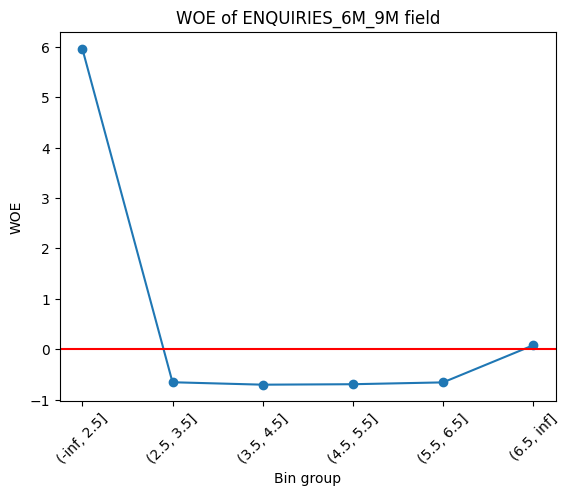

In [57]:
_plot(df_summary)

In [58]:
# df_summary, IV, thres = WOE(df, 'ENQUIRIES_9M_12M', n_bins = 2, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('ENQUIRIES_9M_12M')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_9M_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_9M_12M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of ENQUIRIES_9M_12M column:  0.6796533645607746


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",351,348,3,0.095499,0.000183,6.255103,0.596212,ENQUIRIES_9M_12M
"(2.5, 3.5]",167,16,151,0.004391,0.009232,-0.743178,0.003598,ENQUIRIES_9M_12M
"(3.5, 4.5]",462,46,416,0.012623,0.025434,-0.700531,0.008974,ENQUIRIES_9M_12M
"(4.5, 5.5]",1536,191,1345,0.052415,0.082233,-0.450363,0.013429,ENQUIRIES_9M_12M
"(5.5, 6.5]",2402,222,2180,0.060922,0.133284,-0.782890,0.056652,ENQUIRIES_9M_12M
"(6.5, inf]",15082,2821,12261,0.774149,0.749633,0.032181,0.000789,ENQUIRIES_9M_12M


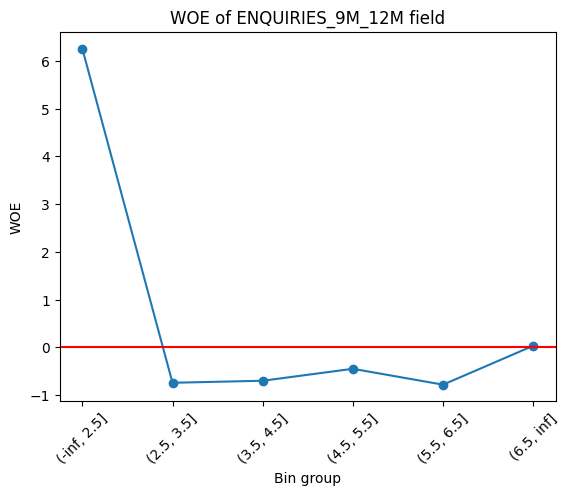

In [59]:
_plot(df_summary)

In [60]:
# df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_BANK_9M_12M', n_bins = 4, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('ENQUIRIES_FROM_BANK_9M_12M')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_BANK_9M_12M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_BANK_9M_12M'] = {'table':df_summary, 'IV':IV}
df_summary

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])


Information Value of ENQUIRIES_FROM_BANK_9M_12M column:  0.6527881909358946


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",3482,1613,1869,0.442645,0.114270,1.354205,0.444688,ENQUIRIES_FROM_BANK_9M_12M
"(2.5, 3.5]",7615,769,6846,0.211032,0.418562,-0.684816,0.142120,ENQUIRIES_FROM_BANK_9M_12M
"(3.5, 4.5]",957,125,832,0.034303,0.050868,-0.394006,0.006527,ENQUIRIES_FROM_BANK_9M_12M
"(4.5, 5.5]",1580,154,1426,0.042261,0.087185,-0.724163,0.032532,ENQUIRIES_FROM_BANK_9M_12M
"(5.5, 6.5]",757,63,694,0.017289,0.042431,-0.897824,0.022573,ENQUIRIES_FROM_BANK_9M_12M
"(6.5, inf]",5609,920,4689,0.252470,0.286684,-0.127088,0.004348,ENQUIRIES_FROM_BANK_9M_12M


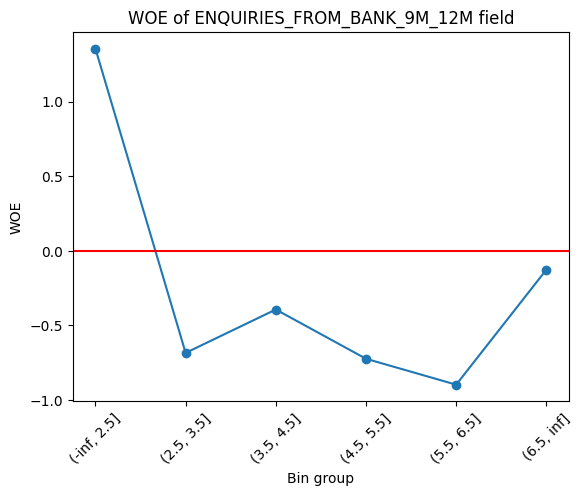

In [61]:
_plot(df_summary)

In [62]:
# df_summary, IV, thres = WOE(df, 'ENQUIRIES_FROM_NON_BANK_3M_6M', n_bins = 2, min_obs= 100, coltype='object')
df_summary, IV, thres = binning_and_WOE_transform('ENQUIRIES_FROM_NON_BANK_3M_6M')
df_summary.fillna(0, inplace=True)
columns.append('ENQUIRIES_FROM_NON_BANK_3M_6M')
IVs.append(IV)
WOE_dict['ENQUIRIES_FROM_NON_BANK_3M_6M'] = {'table':df_summary, 'IV':IV}
df_summary

Information Value of ENQUIRIES_FROM_NON_BANK_3M_6M column:  0.7502943172143777


C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4127919025.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'{colname}_binned')['label'].agg(['count', 'sum'])


,No_Obs,GOOD,BAD,%GOOD,%BAD,WOE,IV,COLUMN
bins,,,,,,,,
"(-inf, 2.5]",348,347,1,0.095225,0.000061,7.350838,0.699534,ENQUIRIES_FROM_NON_BANK_3M_6M
"(2.5, 3.5]",196,30,166,0.008233,0.010149,-0.209278,0.000401,ENQUIRIES_FROM_NON_BANK_3M_6M
"(3.5, 4.5]",607,60,547,0.016465,0.033443,-0.708591,0.012030,ENQUIRIES_FROM_NON_BANK_3M_6M
"(4.5, 5.5]",2322,275,2047,0.075467,0.125153,-0.505847,0.025134,ENQUIRIES_FROM_NON_BANK_3M_6M
"(5.5, 6.5]",1162,136,1026,0.037322,0.062729,-0.519255,0.013193,ENQUIRIES_FROM_NON_BANK_3M_6M
"(6.5, inf]",15365,2796,12569,0.767289,0.768464,-0.001531,0.000002,ENQUIRIES_FROM_NON_BANK_3M_6M


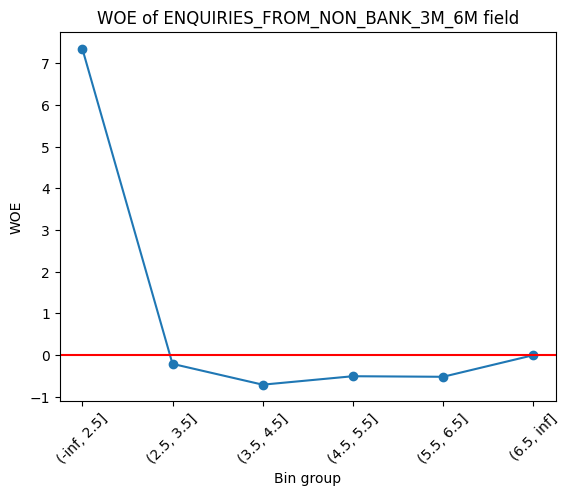

In [63]:
_plot(df_summary)

In [125]:
df_WOE = pd.DataFrame({'column': columns, 'IV': IVs})
def _rank_IV(iv):
  if iv <= 0.02:
    return 'Useless'
  elif iv <= 0.1:
    return 'Weak'
  elif iv <= 0.3:
    return 'Medium'
  elif iv <= 0.5:
    return 'Strong'
  else:
    return 'suspicious'

df_WOE['rank']=df_WOE['IV'].apply(lambda x: _rank_IV(x))
df_WOE.sort_values('IV', ascending=False)

,column,IV,rank
9,NUMBER_OF_LOANS,3.318762e+00,suspicious
35,OUTSTANDING_BAL_LOAN_3M_6M,1.762535e+00,suspicious
36,OUTSTANDING_BAL_LOAN_6M_9M,1.690924e+00,suspicious
39,OUTSTANDING_BAL_LOAN_3M_12M,1.672983e+00,suspicious
38,OUTSTANDING_BAL_LOAN_6M_12M,1.618149e+00,suspicious
...,...,...,...
5,LONG_TERM_COUNT_BANK,1.181287e-02,Useless
2,LONG_TERM_COUNT,1.109983e-02,Useless
92,ENQUIRIES_FROM_NON_BANK_FOR_CC_12M,7.817619e-03,Useless
68,ENQUIRIES_FROM_NON_BANK_FOR_CC_3M,2.271920e-03,Useless


In [126]:
for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['WOE'].index)
    woe = list(WOE_dict[col]['table']['WOE'])
    d = dict(zip(key, woe))
    col_woe = col+'_WOE'
    df[col_woe] = df[col].map(d)
  except:
    print(col)

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\350813944.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_woe] = df[col].map(d)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\350813944.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_woe] = df[col].map(d)
C:\Users\HP\AppData\Local\Temp\ipykernel_13216\350813944.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [127]:
drop_cols = df_WOE[df_WOE['rank']=='Useless']['column'].values

for col in drop_cols:
    if col in columns:
        columns.remove(col)

drop_cols = [col+'_WOE' for col in df_WOE[df_WOE['rank']=='Useless']['column'].values]

df.drop(drop_cols, axis=1, inplace=True)

In [128]:
drop_cols

['LONG_TERM_COUNT_WOE',
 'LONG_TERM_COUNT_BANK_WOE',
 'LONG_TERM_COUNT_NON_BANK_WOE',
 'ENQUIRIES_FROM_NON_BANK_FOR_CC_3M_WOE',
 'ENQUIRIES_FROM_NON_BANK_FOR_CC_6M_WOE',
 'ENQUIRIES_FROM_NON_BANK_FOR_CC_9M_WOE',
 'ENQUIRIES_FROM_NON_BANK_FOR_CC_12M_WOE']

In [129]:
df.head()

,SHORT_TERM_COUNT,MID_TERM_COUNT,LONG_TERM_COUNT,SHORT_TERM_COUNT_BANK,MID_TERM_COUNT_BANK,LONG_TERM_COUNT_BANK,SHORT_TERM_COUNT_NON_BANK,MID_TERM_COUNT_NON_BANK,LONG_TERM_COUNT_NON_BANK,NUMBER_OF_LOANS,...,ENQUIRIES_FROM_BANK_6M_9M_WOE,ENQUIRIES_FROM_BANK_9M_12M_WOE,ENQUIRIES_FROM_BANK_6M_12M_WOE,ENQUIRIES_FROM_BANK_3M_12M_WOE,ENQUIRIES_FROM_NON_BANK_3M_6M_WOE,ENQUIRIES_FROM_NON_BANK_6M_9M_WOE,ENQUIRIES_FROM_NON_BANK_9M_12M_WOE,ENQUIRIES_FROM_NON_BANK_6M_12M_WOE,ENQUIRIES_FROM_NON_BANK_3M_12M_WOE,OUTSTANDING_BAL_ALL_CURRENT_WOE
customer_id,,,,,,,,,,,,,,,,,,,,,
0,6,2,2,3,1,1,4,1,1,5,...,1.233698,1.354205,1.035568,0.740219,-0.001531,-0.030997,-0.069977,-0.007305,0.066021,-0.538157
2,11,2,2,4,1,1,7,1,1,11,...,1.233698,1.354205,1.035568,0.740219,-0.001531,-0.030997,-0.069977,-0.007305,0.066021,-0.195709
3,11,2,2,1,1,1,10,1,1,11,...,-0.729266,1.354205,1.035568,0.740219,-0.001531,-0.030997,-0.255514,-0.411481,-0.472984,-0.376527
4,5,5,2,1,1,1,4,4,1,8,...,-0.525596,-0.724163,-0.741760,0.740219,-0.519255,-0.542949,-0.489580,-0.411481,-0.472984,-0.376527
6,2,2,2,1,1,1,1,1,1,2,...,1.233698,1.354205,1.035568,0.740219,7.350838,0.000000,0.000000,7.353715,5.416389,0.000000


In [130]:
df.isna().sum()

SHORT_TERM_COUNT                      0
MID_TERM_COUNT                        0
LONG_TERM_COUNT                       0
SHORT_TERM_COUNT_BANK                 0
MID_TERM_COUNT_BANK                   0
                                     ..
ENQUIRIES_FROM_NON_BANK_6M_9M_WOE     0
ENQUIRIES_FROM_NON_BANK_9M_12M_WOE    0
ENQUIRIES_FROM_NON_BANK_6M_12M_WOE    0
ENQUIRIES_FROM_NON_BANK_3M_12M_WOE    0
OUTSTANDING_BAL_ALL_CURRENT_WOE       0
Length: 321, dtype: int64

In [131]:
X = df.filter(like='_WOE', axis = 1)
y = df['label']

ids = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, ids, test_size = 0.2, stratify = y, shuffle = True, random_state = 123)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (16000, 102)
X_test shape:  (4000, 102)
y_train shape:  (16000,)
y_test shape:  (4000,)


In [132]:
logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000, fit_intercept=True, tol=0.0001, C=10, penalty='l2')
logit_model.fit(X_train, y_train)
ybar_logistic = logit_model.predict(X_train)
ypred_logistic = logit_model.predict(X_test)
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_logistic)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_logistic)*100))
print('AUC: {}'.format(roc_auc_score(y_test, ypred_logistic)))
print('Gini: {}'.format(2*roc_auc_score(y_test, ypred_logistic)-1))

Accuracy for train data: 89.20625%
Accuracy for validation data: 89.95%
AUC: 0.7386711756765088
Gini: 0.4773423513530175


In [133]:
# log_reg = LogisticRegression()

# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization terms
#     'C': np.logspace(-4, 4, 20),  # Regularization strength
#     'solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg', 'newton-cholesky', 'sag'],  # Optimization algorithms
#     'max_iter': [100, 500, 1000],  # Maximum number of iterations
#     'fit_intercept' : [True, False],
#     'tol': [0.0001, 0.001, 0.01],
# }

# grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)
# best_model = grid_search.best_estimator_
# accuracy = best_model.score(X_test, y_test)
# print("Test set accuracy:", accuracy)

In [134]:
# ybar_logistic = best_model.predict(X_train)
# ypred_logistic = best_model.predict(X_test)

# print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_logistic)*100))
# print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_logistic)*100))
# print('AUC: {}'.format(roc_auc_score(y_test, ypred_logistic)))
# print('Gini: {}'.format(2*roc_auc_score(y_test, ypred_logistic)-1))

In [135]:
def _CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

betas_dict = dict(zip(list(X_train.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

{'SHORT_TERM_COUNT_WOE': 0.38817938620879144,
 'MID_TERM_COUNT_WOE': -0.22141730286809216,
 'SHORT_TERM_COUNT_BANK_WOE': 0.06214763889714149,
 'MID_TERM_COUNT_BANK_WOE': -0.1625776838082188,
 'SHORT_TERM_COUNT_NON_BANK_WOE': -0.4271173271414777,
 'MID_TERM_COUNT_NON_BANK_WOE': -0.15324270136356616,
 'NUMBER_OF_LOANS_WOE': 0.46647135299064035,
 'NUMBER_OF_LOANS_BANK_WOE': 0.01162993203398427,
 'NUMBER_OF_LOANS_NON_BANK_WOE': 0.2618138660697811,
 'NUMBER_OF_CREDIT_CARDS_WOE': 0.2801369223119977,
 'NUMBER_OF_CREDIT_CARDS_BANK_WOE': 0.400906503401435,
 'NUMBER_OF_CREDIT_CARDS_NON_BANK_WOE': 0.011824610623102043,
 'NUMBER_OF_RELATIONSHIP_WOE': -0.10289885027290954,
 'NUMBER_OF_RELATIONSHIP_BANK_WOE': 0.1319867876113878,
 'NUMBER_OF_RELATIONSHIP_NON_BANK_WOE': -0.11290654087129368,
 'NUM_NEW_LOAN_TAKEN_3M_WOE': -0.30979922660460407,
 'NUM_NEW_LOAN_TAKEN_6M_WOE': -0.0068287846990751095,
 'NUM_NEW_LOAN_TAKEN_9M_WOE': 0.18458440786325653,
 'NUM_NEW_LOAN_TAKEN_12M_WOE': 0.03666088849561834,
 'OU

In [136]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in columns:
  for feature, woe in WOE_dict[col]['table']['WOE'].to_frame().iterrows():
      col_woe = col+'_WOE'
      if col_woe not in df.columns:
        continue
      cols.append(col)
      # Add feature
      feature = str(feature)
      features.append(feature)    
      # Add woe
      woe = woe.values[0]
      woes.append(woe)
      # Add beta
      beta = betas_dict[col_woe]
      betas.append(beta)
      # Add score
      score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = X.shape[1])
      scores.append(score)

df_WOE = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
df_WOE.head()

,Columns,Features,WOE,Betas,Scores
0,SHORT_TERM_COUNT,"(-inf, 2.5]",1.807313,0.388179,-45.282205
1,SHORT_TERM_COUNT,"(2.5, 4.5]",0.000000,0.388179,5.324764
2,SHORT_TERM_COUNT,"(4.5, 5.5]",-0.175238,0.388179,10.231630
3,SHORT_TERM_COUNT,"(5.5, 6.5]",1.069379,0.388179,-24.619170
4,SHORT_TERM_COUNT,"(6.5, 7.5]",-0.338291,0.388179,14.797321


In [137]:
df_WOE.head(20)

,Columns,Features,WOE,Betas,Scores
0,SHORT_TERM_COUNT,"(-inf, 2.5]",1.807313,0.388179,-45.282205
1,SHORT_TERM_COUNT,"(2.5, 4.5]",0.000000,0.388179,5.324764
2,SHORT_TERM_COUNT,"(4.5, 5.5]",-0.175238,0.388179,10.231630
3,SHORT_TERM_COUNT,"(5.5, 6.5]",1.069379,0.388179,-24.619170
4,SHORT_TERM_COUNT,"(6.5, 7.5]",-0.338291,0.388179,14.797321
5,SHORT_TERM_COUNT,"(7.5, 8.5]",-0.903783,0.388179,30.631804
6,SHORT_TERM_COUNT,"(8.5, 9.5]",-3.977041,0.388179,116.686768
7,SHORT_TERM_COUNT,"(9.5, 10.5]",0.000000,0.388179,5.324764
8,SHORT_TERM_COUNT,"(10.5, 12.5]",-1.079849,0.388179,35.561844
9,SHORT_TERM_COUNT,"(12.5, 15.5]",-1.145843,0.388179,37.409779


In [138]:
df_WOE[(df_WOE['Columns'] == 'LONG_TERM_COUNT')]

,Columns,Features,WOE,Betas,Scores


In [139]:
df_WOE[df_WOE['Columns']=='ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M']

,Columns,Features,WOE,Betas,Scores
1708,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(-inf, 4.5]",0.000000,0.710453,5.324764
1709,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(4.5, 7.5]",-0.005851,0.710453,5.624608
1710,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(7.5, 8.5]",-0.133678,0.710453,12.175518
1711,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(8.5, 9.5]",-0.230527,0.710453,17.138911
1712,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(9.5, 10.5]",-0.089576,0.710453,9.915383
1713,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(10.5, 11.5]",-0.523594,0.710453,32.158105
1714,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(11.5, 12.5]",-0.213807,0.710453,16.282037
1715,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(12.5, 13.5]",0.342276,0.710453,-12.216307
1716,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(13.5, 14.5]",1.742675,0.710453,-83.984425
1717,ENQUIRIES_FROM_NON_BANK_FOR_LOAN_6M,"(14.5, 15.5]",2.887807,0.710453,-142.670551


In [140]:
df_WOE['Left'] = df_WOE['Features'].apply(lambda x: float(x) if x[0].isdigit() else float(x[1:-1].split(',')[0]))
df_WOE['Right'] = df_WOE['Features'].apply(lambda x: float(x) if x[0].isdigit() else float(x[1:-1].split(',')[1]))

In [141]:
df_WOE[df_WOE['Scores']<0]

,Columns,Features,WOE,Betas,Scores,Left,Right
0,SHORT_TERM_COUNT,"(-inf, 2.5]",1.807313,0.388179,-45.282205,-inf,2.500
3,SHORT_TERM_COUNT,"(5.5, 6.5]",1.069379,0.388179,-24.619170,5.500,6.500
15,MID_TERM_COUNT,"(2.5, 3.5]",-0.584663,-0.221417,-4.013400,2.500,3.500
17,MID_TERM_COUNT,"(4.5, 5.5]",-0.381006,-0.221417,-0.760618,4.500,5.500
19,MID_TERM_COUNT,"(6.5, 7.5]",-0.592249,-0.221417,-4.134563,6.500,7.500
...,...,...,...,...,...,...,...
2259,OUTSTANDING_BAL_ALL_CURRENT,"(1000053.156, 1000053.969]",1.501513,0.468057,-45.371037,1000053.156,1000053.969
2261,OUTSTANDING_BAL_ALL_CURRENT,"(1000075.75, 1000076.906]",2.600125,0.468057,-82.463648,1000075.750,1000076.906
2263,OUTSTANDING_BAL_ALL_CURRENT,"(1000105.25, 1000105.625]",2.194660,0.468057,-68.773869,1000105.250,1000105.625
2273,OUTSTANDING_BAL_ALL_CURRENT,"(1004436.344, 1004455.844]",1.501513,0.468057,-45.371037,1004436.344,1004455.844


In [142]:
columns = [col[:-4] for col in df.columns if '_WOE' in col]

def _search_score(obs, col):
  feature = obs[col]
  score = df_WOE[(df_WOE['Columns'] == col) & (df_WOE['Left'] <= feature) & (df_WOE['Right'] >= feature)]['Scores'].values[0]
  return score

def _total_score(obs, columns = columns):
  scores = dict()
  for col in columns:
    scores[col] = _search_score(obs, col)
  total_score = sum(scores.values())
  return scores, total_score

total_scores = []

for i in range (0, df.shape[0]):
  obs = df[columns].iloc[i, :]
  _, score = _total_score(obs)
  total_scores.append(score)
df['Score'] = total_scores

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4232157929.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Score'] = total_scores


In [143]:
df[['label', 'Score']].head(20)

,label,Score
customer_id,,
0,0,518.680949
2,1,604.017440
3,0,660.337601
4,0,582.393400
6,1,-119.065946
8,1,570.748047
9,0,567.904890
10,1,117.264764
11,0,553.207679


In [144]:
a = 300
b = 850
min_val = df['Score'].min()
max_val = df['Score'].max()

df['Score_norm'] = a + ((df['Score'] - min_val) / (max_val - min_val)) * (b - a)

C:\Users\HP\AppData\Local\Temp\ipykernel_13216\4137506710.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Score_norm'] = a + ((df['Score'] - min_val) / (max_val - min_val)) * (b - a)


In [145]:
df[df['label']==0]['Score_norm'].describe()

count    16356.000000
mean       693.410427
std         37.614134
min        490.840842
25%        670.171851
50%        692.998057
75%        717.171280
max        850.000000
Name: Score_norm, dtype: float64

In [146]:
df[df['label']==1]['Score_norm'].describe()

count    3644.000000
mean      553.692871
std       130.878148
min       300.000000
25%       429.118842
50%       612.590070
75%       663.349439
max       787.515049
Name: Score_norm, dtype: float64

In [147]:
lower_bound_1 = 300
upper_bound_1 = 499

filtered_rows = df[(df['Score_norm'] >= lower_bound_1) & (df['Score_norm'] <= upper_bound_1)]

percentage_1 = (len(filtered_rows) / len(df)) * 100

print(f"Percentage of rows in the range [{lower_bound_1}, {upper_bound_1}]: {percentage_1:.2f}%")

lower_bound_2 = 500
upper_bound_2 = 600

filtered_rows = df[(df['Score_norm'] >= lower_bound_2) & (df['Score_norm'] <= upper_bound_2)]

percentage_2 = (len(filtered_rows) / len(df)) * 100

print(f"Percentage of rows in the range [{lower_bound_2}, {upper_bound_2}]: {percentage_2:.2f}%")

lower_bound_3 = 601
upper_bound_3 = 660

filtered_rows = df[(df['Score_norm'] >= lower_bound_3) & (df['Score_norm'] <= upper_bound_3)]

percentage_3 = (len(filtered_rows) / len(df)) * 100

print(f"Percentage of rows in the range [{lower_bound_3}, {upper_bound_3}]: {percentage_3:.2f}%")

lower_bound_4 = 661
upper_bound_4 = 780

filtered_rows = df[(df['Score_norm'] >= lower_bound_4) & (df['Score_norm'] <= upper_bound_4)]

percentage_4 = (len(filtered_rows) / len(df)) * 100

print(f"Percentage of rows in the range [{lower_bound_4}, {upper_bound_4}]: {percentage_4:.2f}%")

lower_bound_5 = 781
upper_bound_5 = 850

filtered_rows = df[(df['Score_norm'] >= lower_bound_5) & (df['Score_norm'] <= upper_bound_5)]

percentage_5 = (len(filtered_rows) / len(df)) * 100

print(f"Percentage of rows in the range [{lower_bound_5}, {upper_bound_5}]: {percentage_5:.2f}%")

Percentage of rows in the range [300, 499]: 7.00%
Percentage of rows in the range [500, 600]: 2.04%
Percentage of rows in the range [601, 660]: 18.27%
Percentage of rows in the range [661, 780]: 70.95%
Percentage of rows in the range [781, 850]: 1.05%


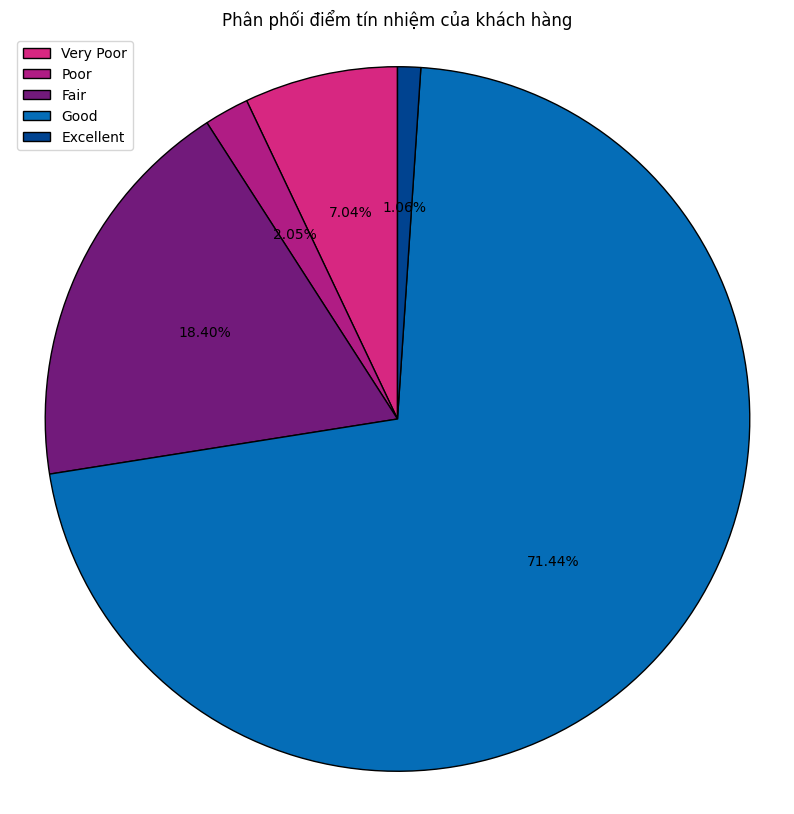

In [148]:
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
sizes = [percentage_1, percentage_2, percentage_3, percentage_4, percentage_5]
colors = ['#D72781','#B01C84','#721A7B','#056DB7','#004390']

plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(sizes, labels=None, autopct='%1.2f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})

plt.legend(patches, labels, loc='upper left')

plt.title('Phân phối điểm tín nhiệm của khách hàng')
plt.axis('equal')

plt.show()

In [149]:
df_1 = df[df['label']==1]

lower_bound_1 = 300
upper_bound_1 = 499

filtered_rows = df_1[(df_1['Score_norm'] >= lower_bound_1) & (df_1['Score_norm'] <= upper_bound_1)]

percentage_1 = (len(filtered_rows) / len(df_1)) * 100

print(f"Percentage of rows in the range [{lower_bound_1}, {upper_bound_1}]: {percentage_1:.2f}%")

lower_bound_2 = 500
upper_bound_2 = 600

filtered_rows = df_1[(df_1['Score_norm'] >= lower_bound_2) & (df_1['Score_norm'] <= upper_bound_2)]

percentage_2 = (len(filtered_rows) / len(df_1)) * 100

print(f"Percentage of rows in the range [{lower_bound_2}, {upper_bound_2}]: {percentage_2:.2f}%")

lower_bound_3 = 601
upper_bound_3 = 660

filtered_rows = df_1[(df_1['Score_norm'] >= lower_bound_3) & (df_1['Score_norm'] <= upper_bound_3)]

percentage_3 = (len(filtered_rows) / len(df_1)) * 100

print(f"Percentage of rows in the range [{lower_bound_3}, {upper_bound_3}]: {percentage_3:.2f}%")

lower_bound_4 = 661
upper_bound_4 = 780

filtered_rows = df_1[(df_1['Score_norm'] >= lower_bound_4) & (df_1['Score_norm'] <= upper_bound_4)]

percentage_4 = (len(filtered_rows) / len(df_1)) * 100

print(f"Percentage of rows in the range [{lower_bound_4}, {upper_bound_4}]: {percentage_4:.2f}%")

lower_bound_5 = 781
upper_bound_5 = 850

filtered_rows = df_1[(df_1['Score_norm'] >= lower_bound_5) & (df_1['Score_norm'] <= upper_bound_5)]

percentage_5 = (len(filtered_rows) / len(df_1)) * 100

print(f"Percentage of rows in the range [{lower_bound_5}, {upper_bound_5}]: {percentage_5:.2f}%")

Percentage of rows in the range [300, 499]: 38.36%
Percentage of rows in the range [500, 600]: 7.24%
Percentage of rows in the range [601, 660]: 27.39%
Percentage of rows in the range [661, 780]: 26.37%
Percentage of rows in the range [781, 850]: 0.03%


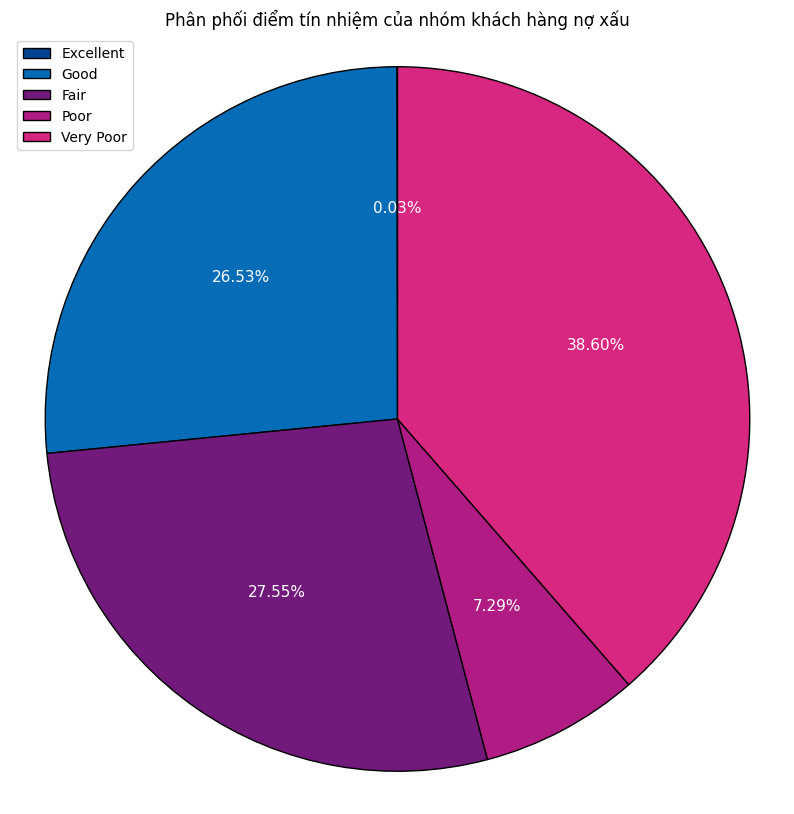

In [150]:
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
sizes = [percentage_1, percentage_2, percentage_3, percentage_4, percentage_5]
colors = ['#D72781','#B01C84','#721A7B','#056DB7','#004390']
labels.reverse()
sizes.reverse()
colors.reverse()
plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(sizes, labels=None, autopct='%1.2f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
plt.legend(patches, labels, loc='upper left')

plt.title('Phân phối điểm tín nhiệm của nhóm khách hàng nợ xấu')
plt.axis('equal')

plt.show()

In [151]:
df_0 = df[df['label']==0]

lower_bound_1 = 300
upper_bound_1 = 499

filtered_rows = df_0[(df_0['Score_norm'] >= lower_bound_1) & (df_0['Score_norm'] <= upper_bound_1)]

percentage_1 = (len(filtered_rows) / len(df_0)) * 100

print(f"Percentage of rows in the range [{lower_bound_1}, {upper_bound_1}]: {percentage_1:.2f}%")

lower_bound_2 = 500
upper_bound_2 = 600

filtered_rows = df_0[(df_0['Score_norm'] >= lower_bound_2) & (df_0['Score_norm'] <= upper_bound_2)]

percentage_2 = (len(filtered_rows) / len(df_0)) * 100

print(f"Percentage of rows in the range [{lower_bound_2}, {upper_bound_2}]: {percentage_2:.2f}%")

lower_bound_3 = 601
upper_bound_3 = 660

filtered_rows = df_0[(df_0['Score_norm'] >= lower_bound_3) & (df_0['Score_norm'] <= upper_bound_3)]

percentage_3 = (len(filtered_rows) / len(df_0)) * 100

print(f"Percentage of rows in the range [{lower_bound_3}, {upper_bound_3}]: {percentage_3:.2f}%")

lower_bound_4 = 661
upper_bound_4 = 780

filtered_rows = df_0[(df_0['Score_norm'] >= lower_bound_4) & (df_0['Score_norm'] <= upper_bound_4)]

percentage_4 = (len(filtered_rows) / len(df_0)) * 100

print(f"Percentage of rows in the range [{lower_bound_4}, {upper_bound_4}]: {percentage_4:.2f}%")

lower_bound_5 = 781
upper_bound_5 = 850

filtered_rows = df_0[(df_0['Score_norm'] >= lower_bound_5) & (df_0['Score_norm'] <= upper_bound_5)]

percentage_5 = (len(filtered_rows) / len(df_0)) * 100

print(f"Percentage of rows in the range [{lower_bound_5}, {upper_bound_5}]: {percentage_5:.2f}%")

Percentage of rows in the range [300, 499]: 0.01%
Percentage of rows in the range [500, 600]: 0.88%
Percentage of rows in the range [601, 660]: 16.24%
Percentage of rows in the range [661, 780]: 80.88%
Percentage of rows in the range [781, 850]: 1.28%


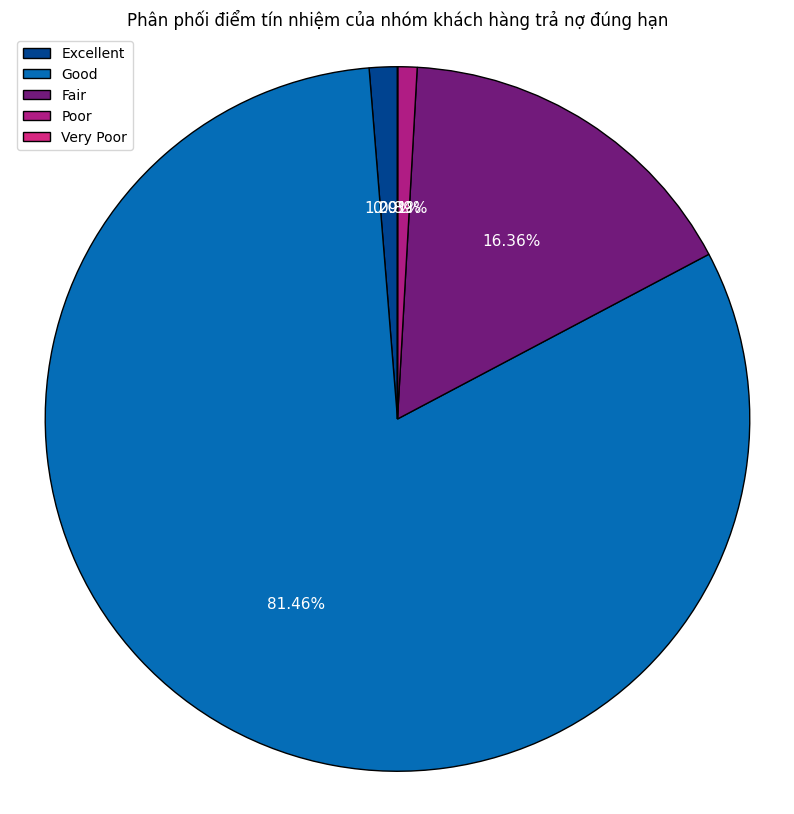

In [152]:
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
sizes = [percentage_1, percentage_2, percentage_3, percentage_4, percentage_5]
colors = ['#D72781','#B01C84','#721A7B','#056DB7','#004390']

labels.reverse()
sizes.reverse()
colors.reverse()
plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(sizes, labels=None, autopct='%1.2f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
plt.legend(patches, labels, loc='upper left')

plt.title('Phân phối điểm tín nhiệm của nhóm khách hàng trả nợ đúng hạn')
plt.axis('equal')

plt.show()